# Finding the next Austin
### A cluster analysis of housing price growth in ~60 US cities since 2009 and a lagged index of Austin's housing price index
Xander Snyder's capstone project for PropertyQuants, a graduate level course in data science specifically for real estate applications. For more information on Property Quants, see: https://propertyquants.com/

Over the last decade, Austin TX has seen explosive growth in housing prices. Following the 2008-2009 financial crisis, Austin's housing market stagnated but began to grow quickly as people from higher cost of living cities (many on the coasts) began to look for cheaper places to live. Austin has been red hot for a number of years now, so an obvious question is: what city may next experience similarly explosive growth? 

This analysis explores that question with a cluster analys. Starting from housing price indices, acquired from FRED, I ask: which cities experienced similar growth trends over the last year? Then, with an eye on Austin, I ask: which cities are *currently* experiencing similar growth trends as Austin did 7 years ago? A period of 7 years was chosen since, 7 years ago, Austin's housing price growth had already firmly begun but the growth had not yet become explosive. By comparing current housing prices to lagged prices, I hope to identify some cities that are just beginning to experience longer-term secular growth. 

Clustering cities should be considered the first step. A follow-up analysis could include a multivariate time series analysis that regresses housing price index growth on a number of demographic metrics. If certain demographic characteristics repeatedly appear to have a significant auto or crosscorrelation, then those demographic features could be used as explanatory variables in a new model.

All housing price indices come from FRED's repository of data. The data sets originally come from the U.S. Federal Housing Finance Agency.

Restarting & running this entire notebook takes ~3 minutes. The delay is caused primarly by 1) auto-adjusting label text in the scatter plot to prevent overlapping and 2) querying latitude and longitude from GeoPy's API in the map section.

Note that, after beginning this project, I came across an article by Cadre Insights with the same title. It's goal is identical to mine, but its approach is different. Since I began working on this project before I came across this article, I kept the same name. 

Read Cadre's approach here: https://cadre.com/insights/finding-the-next-austin/

In [1]:
# Import packages
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d # for 3D charts in EDA
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from geopy.geocoders import Nominatim # COMMENT WHAT THIS IS FOR
import folium

# Adjust_text is a package used to move text on scatterplots to limit clutter
# Works well, but takes a long time to do with 1) many data points and 2) long label names
# see: https://github.com/Phlya/adjustText/wiki
from adjustText import adjust_text 

In [2]:
# Unomment next line if using dark mode in Jupyter Notebook
# plt.style.use('ggplot')

### Import data (from 1990-present), and separate into two data frames: one with all dates since 1990, and beginning in 3Q2009, when the Great Recession officially ended.

In [3]:
# Import data
data_index = pd.read_csv('data/merged_data/ts_index_all_cities.csv')
data_growth = pd.read_csv('data/merged_data/ts_growth_all_cities.csv')

data_index.rename(columns={"Unnamed: 0": "City"}, inplace=True)
data_growth.rename(columns={"Unnamed: 0": "City"}, inplace=True)

data_index.set_index('City', inplace=True)
data_growth.set_index('City', inplace=True)

# # Drop two cities that, upon initial investigation, required their own groups
### NO LONGER APPEARS NECESSARY
# data_growth.drop(['Newport_County_RI', 'Bismarck_ND'], inplace=True)

# Create a subset for post-recession data
data_post_rec_growth = data_growth.iloc[:, 78:].copy()
data_post_rec_index = data_index.iloc[:, 78:].copy()

### Stanardized the data so it can be transformed with Principal Components Analysis (PCA), then conduct PCA.

In [4]:
# Scale data, which is necessary for input data for Principal Components Analysis (PCA)
ss_data = StandardScaler().fit_transform(data_growth)
ss_data_post_rec = StandardScaler().fit_transform(data_post_rec_growth)

# Rejoin the city names (in pandas df) with the np.array() containing standardized vals
ss_df = pd.DataFrame(ss_data, columns = data_growth.columns)
ss_df_post_rec = pd.DataFrame(ss_data_post_rec, columns = data_post_rec_growth.columns)

ss_df.index = data_growth.index
ss_df_post_rec.index = data_post_rec_growth.index

In [5]:
# Conduct PCA, transform standardized data, and save explained variance data for
# all dates and post-recession data.
pca = PCA()
pca_post_rec = PCA()

pca.fit_transform(ss_data)
pca_post_rec.fit_transform(ss_data_post_rec)

pca_variance = pca.explained_variance_
pca_variance_post_rec = pca_post_rec.explained_variance_

### Variance explained by Principal Component

In [6]:
def print_cum_var(pca_variance, return_vals=False):
    '''
    Print the cumulative variance for each principal component, given a numpy array
    of principal components (ie, the return values from pca.explained_variance_)
    
    Parameters:
    pca_variance should be a numpy array of the variances from a pca analysis,
    that is, pca_object.explained_variance_
    
    Set return_vals == False to have function return a numpy array with
    cumulative explained variance vals.
    '''
    
    val_list = []
    print("n\tCumulative Variance (approx):)")
    for i in range(len(pca_variance)):
        print("%s \t%.2f%%" % (i+1, 100*pca_variance[0:i+1].sum()/pca_variance.sum()))
        
        if return_vals == True:
            val_list.append(100*pca_variance[0:i+1].sum() / pca_variance.sum())
            
    if return_vals == True:
        return np.array(val_list) # return the list only if set by user

In [7]:
print_cum_var(pca_variance)

n	Cumulative Variance (approx):)
1 	21.83%
2 	33.98%
3 	41.44%
4 	46.31%
5 	50.62%
6 	54.64%
7 	58.07%
8 	61.24%
9 	64.26%
10 	66.92%
11 	69.39%
12 	71.52%
13 	73.58%
14 	75.43%
15 	77.21%
16 	78.78%
17 	80.26%
18 	81.69%
19 	83.06%
20 	84.27%
21 	85.40%
22 	86.52%
23 	87.53%
24 	88.40%
25 	89.18%
26 	89.91%
27 	90.64%
28 	91.31%
29 	91.97%
30 	92.55%
31 	93.11%
32 	93.66%
33 	94.15%
34 	94.60%
35 	95.03%
36 	95.45%
37 	95.85%
38 	96.22%
39 	96.56%
40 	96.87%
41 	97.16%
42 	97.43%
43 	97.68%
44 	97.92%
45 	98.14%
46 	98.34%
47 	98.51%
48 	98.68%
49 	98.83%
50 	98.98%
51 	99.10%
52 	99.22%
53 	99.33%
54 	99.43%
55 	99.53%
56 	99.61%
57 	99.69%
58 	99.76%
59 	99.81%
60 	99.86%
61 	99.91%
62 	99.95%
63 	99.98%
64 	100.00%
65 	100.00%


In [8]:
print_cum_var(pca_variance_post_rec)

n	Cumulative Variance (approx):)
1 	24.52%
2 	34.48%
3 	41.57%
4 	48.47%
5 	53.88%
6 	58.90%
7 	63.40%
8 	67.42%
9 	70.88%
10 	73.84%
11 	76.49%
12 	78.87%
13 	81.12%
14 	83.25%
15 	84.96%
16 	86.61%
17 	88.11%
18 	89.43%
19 	90.64%
20 	91.68%
21 	92.62%
22 	93.44%
23 	94.22%
24 	94.90%
25 	95.49%
26 	96.01%
27 	96.51%
28 	96.99%
29 	97.42%
30 	97.79%
31 	98.12%
32 	98.42%
33 	98.68%
34 	98.88%
35 	99.07%
36 	99.24%
37 	99.39%
38 	99.52%
39 	99.62%
40 	99.71%
41 	99.78%
42 	99.84%
43 	99.89%
44 	99.93%
45 	99.96%
46 	99.98%
47 	100.00%


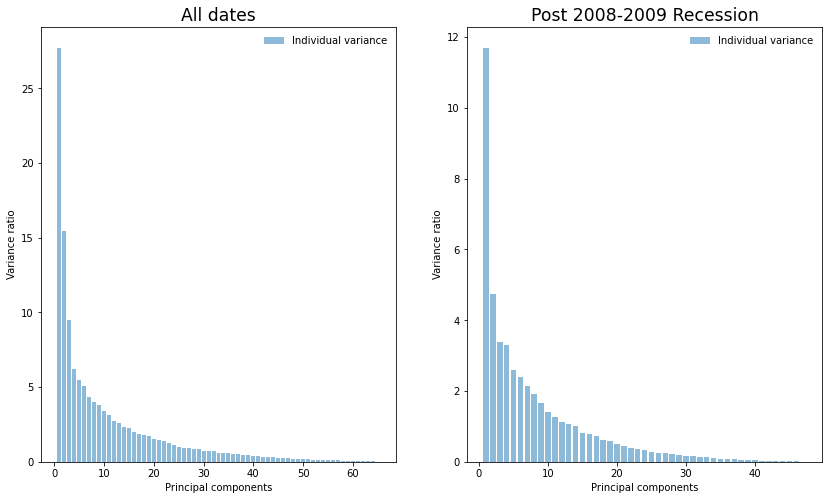

In [9]:
# Show the cumulative explained variance in a chart
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].bar(range(1, min(ss_data.shape)+1), pca_variance, 
          alpha=0.5, align='center',
       label='Individual variance')
ax[0].legend()
ax[0].set_ylabel('Variance ratio')
ax[0].set_xlabel('Principal components')
ax[0].set_title('All dates', fontsize = 'xx-large', color="black")

# Set legend text color to black
leg = ax[0].legend(framealpha = 0, loc = 'best')
for text in leg.get_texts():
    plt.setp(text, color = 'black')

ax[1].bar(range(1, min(ss_data_post_rec.shape)+1), pca_variance_post_rec, 
          alpha=0.5, align='center',
       label='Individual variance')
ax[1].legend()
ax[1].set_ylabel('Variance ratio')
ax[1].set_xlabel('Principal components')
ax[1].set_title('Post 2008-2009 Recession', fontsize = 'xx-large', color="black")

leg = ax[1].legend(framealpha = 0, loc = 'best')
for text in leg.get_texts():
    plt.setp(text, color = 'black')


plt.show()

**Observations:** the post-recession data can be slightly better explained with fewer principal components. This makes sense since it is a shorter period of time, so there is  less overall variance to account for. The marginal increase in explained variance for each incremental pincipal component decreases meaningfully beyond the first three principal components for both all dates and post Great Recession. This indicates that a 3D plot of the first 3 principal components may be a worthwhile step in EDA, since there is still a meaningful amount of variance explained by the 3rd component. This 3D EDA will be conducted below.

### Define functions that will be used to cluster & plot the clusters of cities with similar housing price growth.

In [10]:
def get_reduced_df(ss_df, n_components=6, k_clusters=6, gmm_clusters=6, max_iter=10000):
    '''
    Takes a dataframe with standardized input values and return a dataframe that
    contains only the first n_components number of principal components, as well as
    the groupings according to both K-Means and a Gaussian Mixture Model (GMM).
    
    ss_df: data frame to reduce for cluster plotting
    n_components: number of principal components to use
    k_clusters: number of kmeans centroids to use in the cluster analysis
    gmm_clusters: number of Gaussian mixture model clusters to use in analysis
    
    returns: a df that can subsequently used in plotting the clusters. 
    See function plot_clusters
    '''
    
    reduced_data = PCA(n_components=n_components).fit_transform(ss_df)
    
    # Create k-means object & fit on the reduced data (that is, the principal components)
    kmeans = KMeans(n_clusters = k_clusters, max_iter=max_iter)
    kmeans.fit(reduced_data)
    kmeans_cluster_labels = kmeans.predict(reduced_data)
    
    # Do the same for Gaussian mixtures
    gmm = mixture.GaussianMixture(n_components=gmm_clusters, covariance_type='diag',
                                 max_iter = 10000)
    gmm.fit(reduced_data)
    gmm_cluster_labels = gmm.predict(reduced_data)
    
    # Create data frame with names of all cities and their principal components
    reduced_df = pd.concat([pd.Series(ss_df.index), pd.DataFrame(reduced_data)], 
              axis=1)

    # Add two columns with groups. One for k-means, and one for Gaussian Mixture
    reduced_df = pd.concat([reduced_df, pd.Series(kmeans_cluster_labels, 
                                                  name="kmeans_group")], axis=1)

    reduced_df = pd.concat([reduced_df, pd.Series(gmm_cluster_labels, 
                                                  name="gmm_group")], axis=1)
    
    return reduced_df.set_index('City')
    

In [11]:
def plot_clusters(reduced_df, cluster_type="kmeans_group", adjust_text_on=False, radius=0.5,
                 color_list = ["blue", "orange", "green", "red", "purple", "brown", "pink"]):
    
    '''
    Plot clusters of either K-means or Gaussian mixtures. Takes several seconds to run 
        as the adjust_text() function takes some time to find optimal positioning of text.
    
    Parameters
    reduced_df: reduced data frame with only principal components, such as the return value in
        get_reduced_df()
    cluster_type: string, either "kmeans_group" or "gmm_group"
    adjust_text: set to True to reduce text clutter on the scatter plot. 
        Setting to True results in a longer run time, as the adjust_text package minimizes
        clutter iteratively.
    color_list = a list containing the colors for clusters, in a given order. Use this
        parameter to maintain color consistency between Austin's cluster color on the
        cluster plot, and its color on the map.
    '''
    
    fig, ax = plt.subplots(figsize=(25, 25))
    cluster_type_title = ''
    if cluster_type == "kmeans_group":
        groups = reduced_df.groupby("kmeans_group")
        cluster_type_title = 'K-means clusters'
    else:
        groups = reduced_df.groupby("gmm_group")
        cluster_type_title = 'Gaussian Mixture clusters'
    
    i = 0 # create counter to apply the correct color
    for name, group in groups:
        ax.plot(group[0], group[1], marker="o", linestyle="", label=name,
               color = color_list[i])
        i += 1 # increment
    ax.legend()

    annotations_list = []
    for i, txt in enumerate(reduced_df.index.values):
        annotations_list.append(ax.text(reduced_df.iloc[i, 0], reduced_df.iloc[i, 1], txt))

    if adjust_text_on == True:
        adjust_text(annotations_list)
    
    # Draw a red circle over Austin
    # Later: expand functionality to any city
    austin_pcs = reduced_df.loc['Austin_TX'].copy()
    cir = plt.Circle((austin_pcs[0], austin_pcs[1]), radius, color='magenta', 
                     fill=False, linewidth=3)
    ax.set_aspect('equal', adjustable='datalim')
    ax.add_patch(cir)

    plt.title(cluster_type_title, c='white', fontsize=50)

In [12]:
def get_lagged_df(ss_df, lead_quarters=4, city_name='Austin_TX'):
    '''
    Compare current period prices for cities against the past prices for Austin
    (or any other city - although this functionality has not yet been tested).
    
    ss_df: standardized dataframe of values to lag
    '''
    lagged_df = ss_df.T.copy()
    lagged_df.index = pd.to_datetime(lagged_df.index)
    lagged_df[city_name] = lagged_df['Austin_TX'].shift(lead_quarters) # How far ahead Austin is 
    lagged_df = lagged_df.T # flip back over to get reduced df and plot
    lagged_df = lagged_df.dropna(axis=1)
    
    return lagged_df

## Investigate clustering metrics

* Generally want Silhouette score to be higher
* Generally want CH index to be higher
* Generally want DB to be lower.

# Define functions for cluster diagnostics

In [13]:
def get_cluster_scores(n_components, n_clusters, ss_df, cluster_type="k",
                      print_diag = True):
    '''
    Loop through n_clusters from 2 through 10 and print clustering scores for each. 
    Used to identify number of PCA components and clusters to use in cluster analysis
    
    n_components: number of principal components used in df reduction
    ss_df: standardized dataframe
    cluster_type: either "k" or "gmm", indicating which cluster algorithm to use.
    print_diag: if true, print out diagnostics instead of just returning list
    '''
    
    reduced_data = PCA(n_components=n_components).fit_transform(ss_df)

    # Loop through number of clusters, from 2 to 10
    sil_euc_list = [] # silhouette socre using euclidean distances
    sil_man_list = [] # silhoeutte score using manhattan distances
    calinski_harabasz_list = []
    davies_bouldin_list = []
    if cluster_type == "k":
        for i in range(2, n_clusters+1):
            kmeans_model = KMeans(n_clusters=i, random_state=1).fit(reduced_data)
            labels = kmeans_model.labels_

            # Append scores to their respectiv lists
            sil_euc_list.append(metrics.silhouette_score(reduced_data, labels, metric = "euclidean"))
            sil_man_list.append(metrics.silhouette_score(reduced_data, labels, metric = "manhattan"))
            calinski_harabasz_list.append(metrics.calinski_harabasz_score(reduced_data, labels))
            davies_bouldin_list.append(metrics.davies_bouldin_score(reduced_data, labels))
    elif cluster_type == "gmm":
        for i in range(2, n_clusters+1):
            gmm = mixture.GaussianMixture(n_components=i, covariance_type='diag',
                                                random_state=1).fit(reduced_data)
            pred = gmm.predict(reduced_data) # get prediction to pass to metrics scores

            # Append scores to their respectiv lists
            sil_euc_list.append(metrics.silhouette_score(reduced_data, pred, metric = "euclidean"))
            sil_man_list.append(metrics.silhouette_score(reduced_data, pred, metric = "manhattan"))
            calinski_harabasz_list.append(metrics.calinski_harabasz_score(reduced_data, pred))
            davies_bouldin_list.append(metrics.davies_bouldin_score(reduced_data, pred))

    if print_diag == True:
        # Print out diagnostics
        print("\n")
        print("Silhouette Scores")
        print("Euclidean distance")

        # Since for loop goes from n_clusters = 2 through 11, need to add 2 to the 
        # index representing the max/min value.
        print("Max: ", round(max(sil_euc_list), 4), "\n",
              "n_clusters: ", pd.Series(sil_euc_list).idxmax() + 2) 
        print("Manhattan distance")
        print("Max: ", round(max(sil_man_list), 4), "\n",
              "n_clusters: ", pd.Series(sil_man_list).idxmax() + 2)

        print('\n')
        print("Calinski_Harabasz Score")
        print("Max: ", round(max(calinski_harabasz_list), 4), "\n",
             "n_clusters: ", pd.Series(calinski_harabasz_list).idxmax() + 2)

        print('\n')
        print("Davis Bouldin Score")
        print("Min: ", round(min(davies_bouldin_list), 4), "\n",
             "n_clusters: ", pd.Series(davies_bouldin_list).idxmin() + 2)
    
    # Recall that id = 0 fore ach of the returned list refers to
    # 2 clusters. Relevant for graphing later
    return sil_euc_list, sil_man_list, calinski_harabasz_list, davies_bouldin_list

In [14]:
def get_chart_diagnostics(euc_list, man_list, ch_list, db_list):
    """
    Show diagnostic charts for different cluster scores
    """
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 8))
    
    xi = list(range(2, len(euc_list) +2 ))
    axs[0].plot(xi, euc_list)
    axs[0].set_title("Silhouette, Euclidean")

    axs[1].plot(xi, man_list)
    axs[1].set_title("Silhouette, Manhattan")

    axs[2].plot(xi, ch_list)
    axs[2].set_title("Calinski Harabasz")

    axs[3].plot(xi, db_list)
    axs[3].set_title("Davies Bouldin")

    plt.show()

# Cluster diagnostics

## K-means diagnostics

Number of principal components:  2


Silhouette Scores
Euclidean distance
Max:  0.4812 
 n_clusters:  2
Manhattan distance
Max:  0.4752 
 n_clusters:  2


Calinski_Harabasz Score
Max:  111.9606 
 n_clusters:  20


Davis Bouldin Score
Min:  0.4714 
 n_clusters:  20


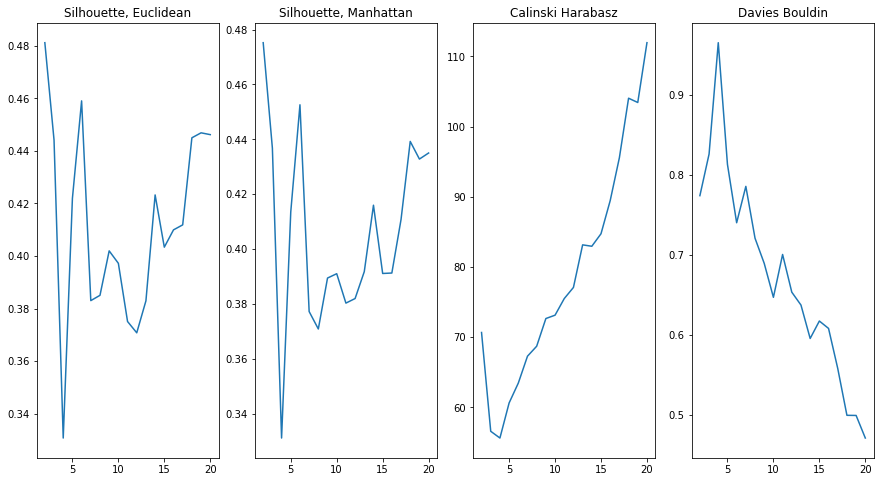



Number of principal components:  3


Silhouette Scores
Euclidean distance
Max:  0.4468 
 n_clusters:  3
Manhattan distance
Max:  0.4087 
 n_clusters:  3


Calinski_Harabasz Score
Max:  54.6108 
 n_clusters:  20


Davis Bouldin Score
Min:  0.6472 
 n_clusters:  19


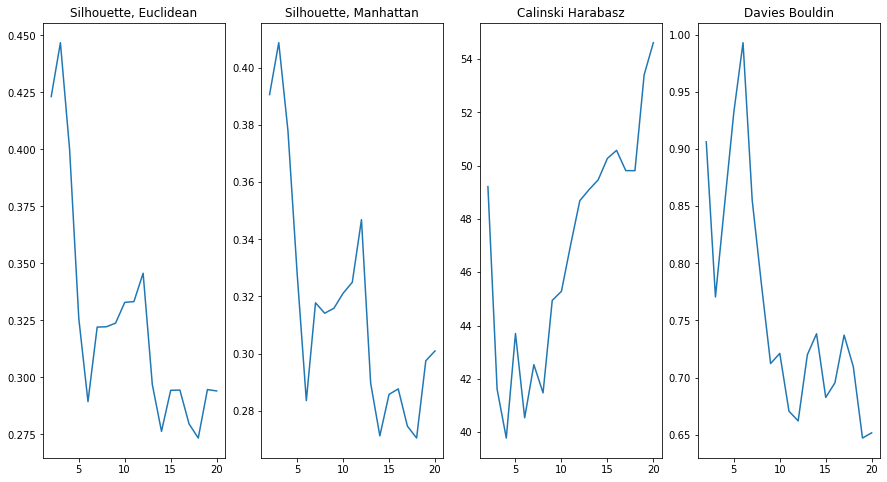



Number of principal components:  4


Silhouette Scores
Euclidean distance
Max:  0.3885 
 n_clusters:  3
Manhattan distance
Max:  0.3468 
 n_clusters:  3


Calinski_Harabasz Score
Max:  38.0998 
 n_clusters:  2


Davis Bouldin Score
Min:  0.6997 
 n_clusters:  20


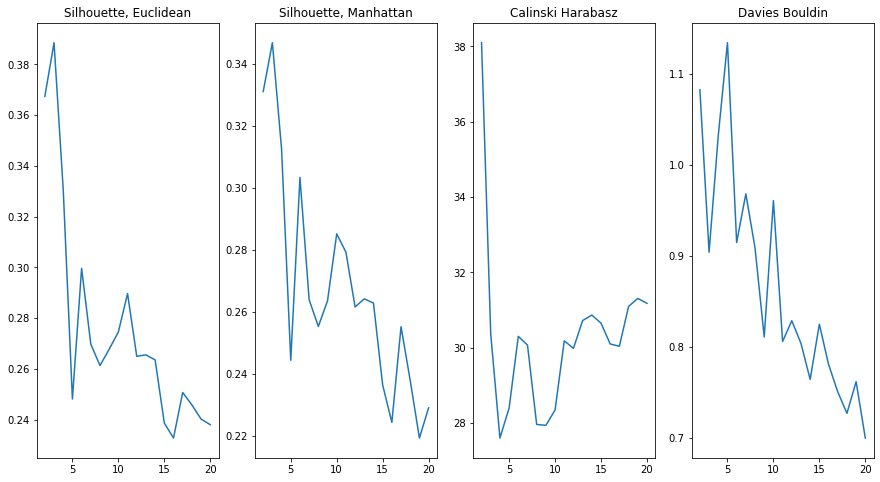



Number of principal components:  5


Silhouette Scores
Euclidean distance
Max:  0.335 
 n_clusters:  3
Manhattan distance
Max:  0.2884 
 n_clusters:  3


Calinski_Harabasz Score
Max:  32.3218 
 n_clusters:  2


Davis Bouldin Score
Min:  0.7636 
 n_clusters:  20


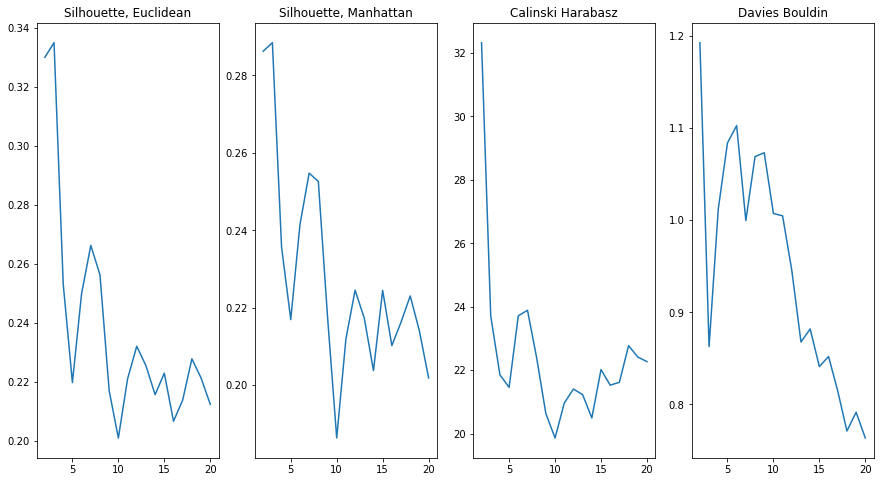



Number of principal components:  6


Silhouette Scores
Euclidean distance
Max:  0.3106 
 n_clusters:  3
Manhattan distance
Max:  0.2598 
 n_clusters:  3


Calinski_Harabasz Score
Max:  28.4177 
 n_clusters:  2


Davis Bouldin Score
Min:  0.7533 
 n_clusters:  20


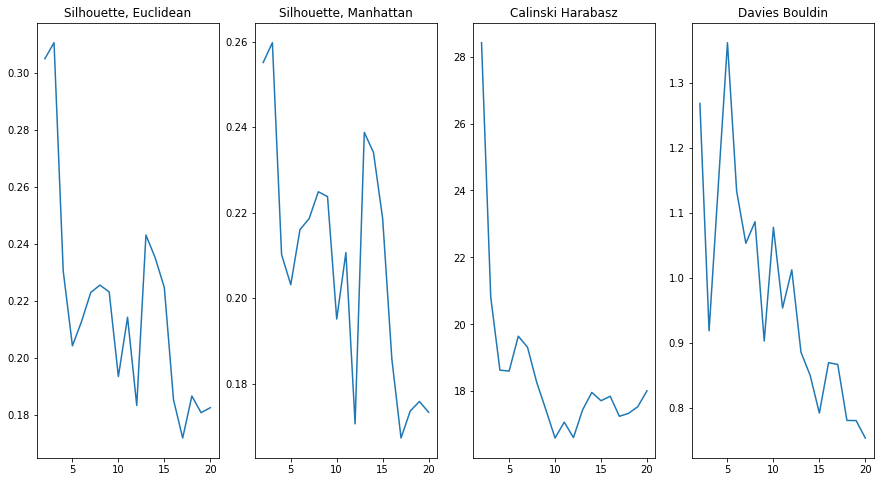



Number of principal components:  7


Silhouette Scores
Euclidean distance
Max:  0.2831 
 n_clusters:  2
Manhattan distance
Max:  0.2299 
 n_clusters:  2


Calinski_Harabasz Score
Max:  25.6136 
 n_clusters:  2


Davis Bouldin Score
Min:  0.7954 
 n_clusters:  18


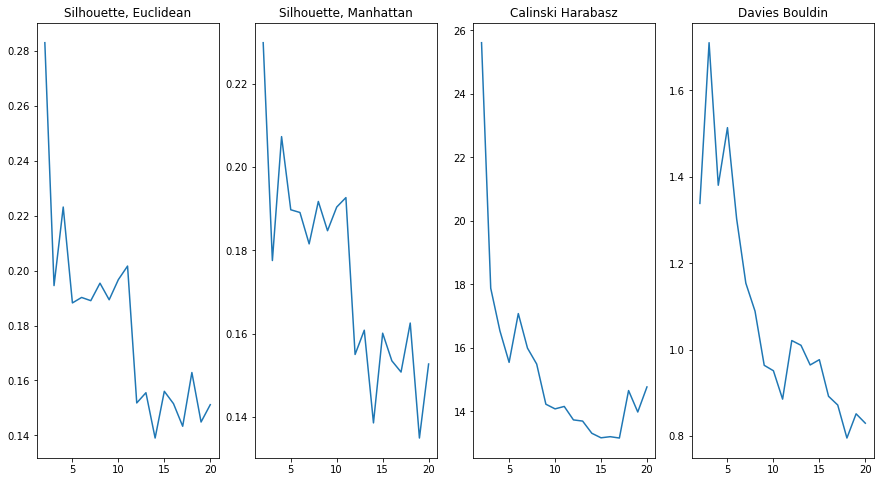



Number of principal components:  8


Silhouette Scores
Euclidean distance
Max:  0.2657 
 n_clusters:  2
Manhattan distance
Max:  0.2107 
 n_clusters:  2


Calinski_Harabasz Score
Max:  23.5237 
 n_clusters:  2


Davis Bouldin Score
Min:  0.8087 
 n_clusters:  19


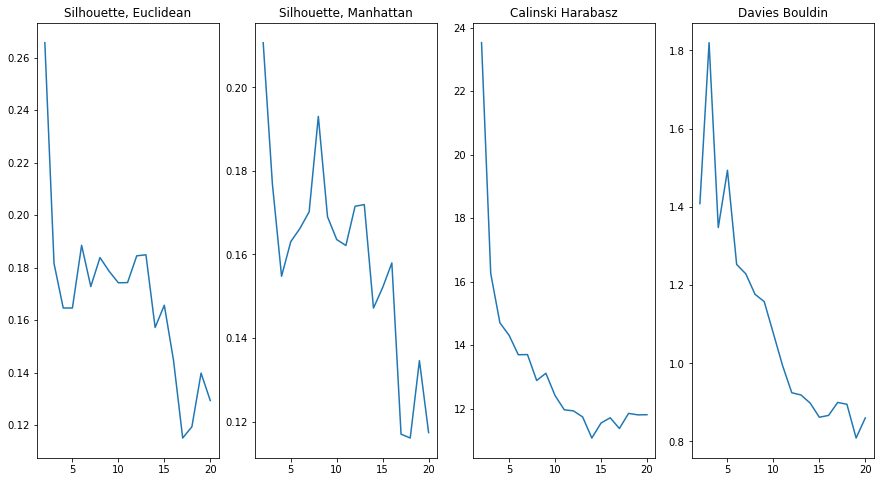



Number of principal components:  9


Silhouette Scores
Euclidean distance
Max:  0.276 
 n_clusters:  3
Manhattan distance
Max:  0.2181 
 n_clusters:  3


Calinski_Harabasz Score
Max:  21.989 
 n_clusters:  2


Davis Bouldin Score
Min:  0.8271 
 n_clusters:  18


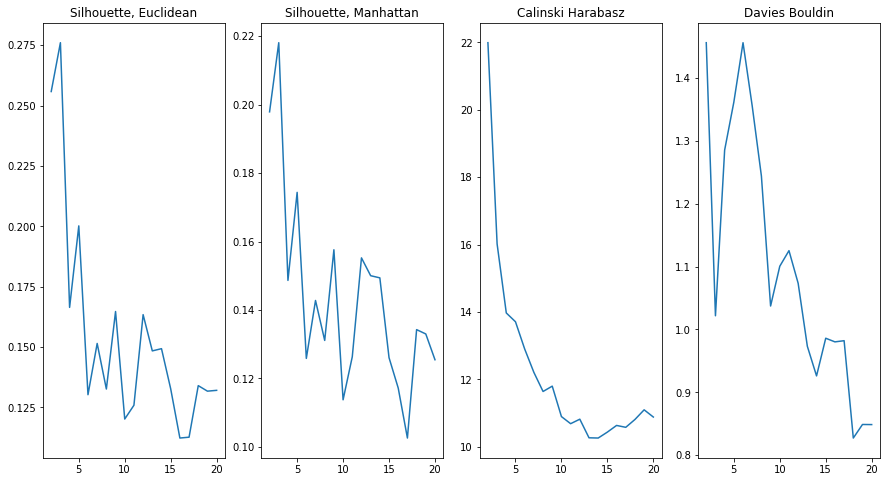



Number of principal components:  10


Silhouette Scores
Euclidean distance
Max:  0.2661 
 n_clusters:  3
Manhattan distance
Max:  0.205 
 n_clusters:  3


Calinski_Harabasz Score
Max:  20.8142 
 n_clusters:  2


Davis Bouldin Score
Min:  0.7694 
 n_clusters:  20


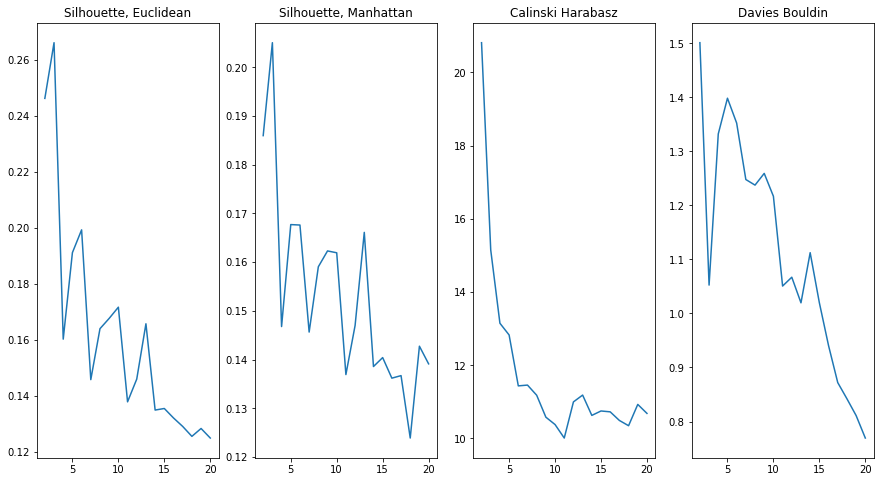

In [15]:
# Show diagnostics by number of principal components
for i in range(2, 11):
    print("Number of principal components: ", i)
    euc_list, man_list, ch_list, db_list = get_cluster_scores(
    n_components=i, n_clusters=20, ss_df=ss_df_post_rec, cluster_type="k")

    get_chart_diagnostics(euc_list, man_list, ch_list, db_list)
    print('\n')

**Observations**: 
Silhouette Scores for both Euclidean and Manhattan distance appear to perform best at very low cluster numbers, either 2 or 3. 

The Davies-Bouldin Score seems to consistently indicate better partitioned clusters when there are more clusters. This makes some intuitive sense, since lots of clusters means fewer cities in each cluster. 

We can see the curse of dimensionality in action here. As the number of principal components increases - that is, as the number of dimensions used in our distance metric increase - the cluster performance metrics deteriorate (Silhouette scores go down, CH scre goes down, and DB index goes up). The challenge with using only 2 principal components is, as shown above, only ~35% of cumulative variance is explained in those first 2 components. Two reasonable choices would be 5 principal components, which account for 50% of explained variance, or 8 principal components which accounts for 2/3 of explained variance (but exhibits poorer clustering performance).

#### Review optimal clustering numbers for kmeans, for PCA=5 and 8

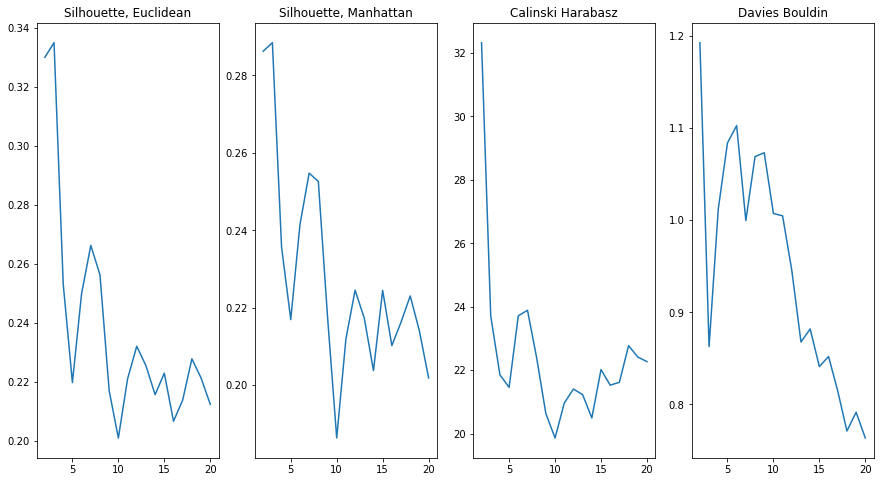

,euc_sil,man_sil,ch,db
2,0.329994,0.286249,32.321783,1.192419
3,0.334963,0.288450,23.706429,0.862778
4,0.253077,0.235643,21.850273,1.012071
5,0.219698,0.216926,21.455907,1.083621
6,0.249894,0.241448,23.711574,1.102509
7,0.266230,0.254759,23.886963,0.999391
8,0.256215,0.252600,22.383424,1.068847
9,0.216946,0.217695,20.629865,1.073052
10,0.200890,0.186334,19.858606,1.007147
11,0.220923,0.211885,20.959308,1.004580


In [16]:
# Review optimal clustering numbers using 5 principal components and kmeans
euc_list, man_list, ch_list, db_list = get_cluster_scores(
    n_components=5, n_clusters=20, ss_df=ss_df_post_rec, cluster_type="k", print_diag=False)

get_chart_diagnostics(euc_list, man_list, ch_list, db_list)

pc5_scores = pd.DataFrame([euc_list, man_list, ch_list, db_list]).T
pc5_scores.columns = ["euc_sil", "man_sil", "ch", "db"]
new_index = pc5_scores.index.values + 2
pc5_scores = pc5_scores.set_index(new_index)
pc5_scores

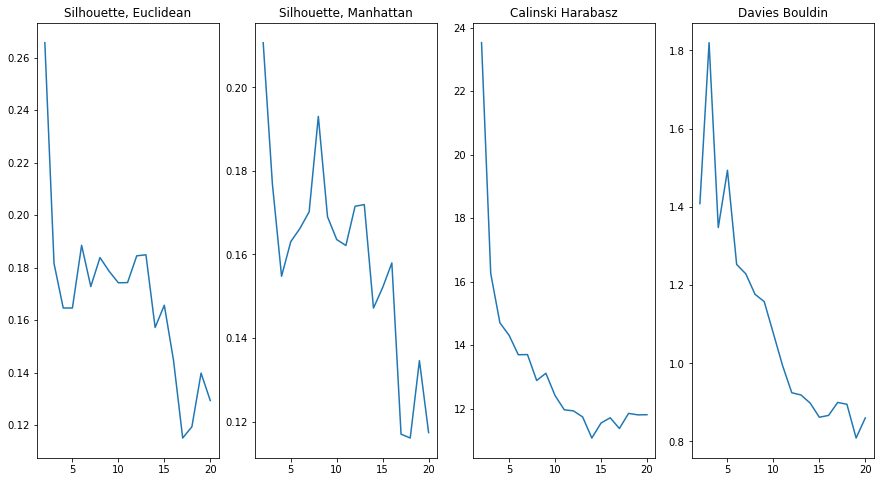

,euc_sil,man_sil,ch,db
2,0.265724,0.210670,23.523692,1.408043
3,0.181597,0.176888,16.252560,1.819673
4,0.164639,0.154783,14.700511,1.346991
5,0.164636,0.163060,14.308099,1.493421
6,0.188523,0.166226,13.697026,1.252670
7,0.172816,0.170192,13.701698,1.228493
8,0.183853,0.193029,12.886434,1.176287
9,0.178616,0.169019,13.113106,1.157620
10,0.174241,0.163564,12.410916,1.075944
11,0.174316,0.162149,11.963674,0.993750


In [17]:
# Review optimal clustering numbers using 8 principal components and kmeans
euc_list, man_list, ch_list, db_list = get_cluster_scores(
    n_components=8, n_clusters=20, ss_df=ss_df_post_rec, cluster_type="k", print_diag=False)

get_chart_diagnostics(euc_list, man_list, ch_list, db_list)

# Create data frame to show exact scores at each cluster number
pc8_scores = pd.DataFrame([euc_list, man_list, ch_list, db_list]).T
pc8_scores.columns = ["euc_sil", "man_sil", "ch", "db"]
new_index = pc8_scores.index.values + 2
pc8_scores = pc8_scores.set_index(new_index)
pc8_scores

K means
Use n_cluster = 7 for pca = 5 <BR>
Use n_cluster = 11 for pca=8

## GMM cluster diagnostics

Number of principal components:  2


Silhouette Scores
Euclidean distance
Max:  0.4812 
 n_clusters:  2
Manhattan distance
Max:  0.4752 
 n_clusters:  2


Calinski_Harabasz Score
Max:  94.0058 
 n_clusters:  19


Davis Bouldin Score
Min:  0.4939 
 n_clusters:  19


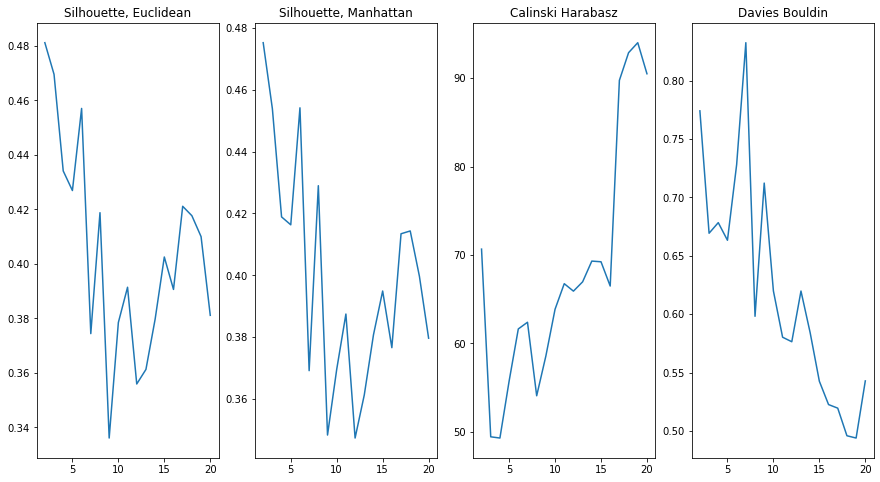



Number of principal components:  3


Silhouette Scores
Euclidean distance
Max:  0.4361 
 n_clusters:  3
Manhattan distance
Max:  0.4049 
 n_clusters:  2


Calinski_Harabasz Score
Max:  45.7585 
 n_clusters:  16


Davis Bouldin Score
Min:  0.6417 
 n_clusters:  20


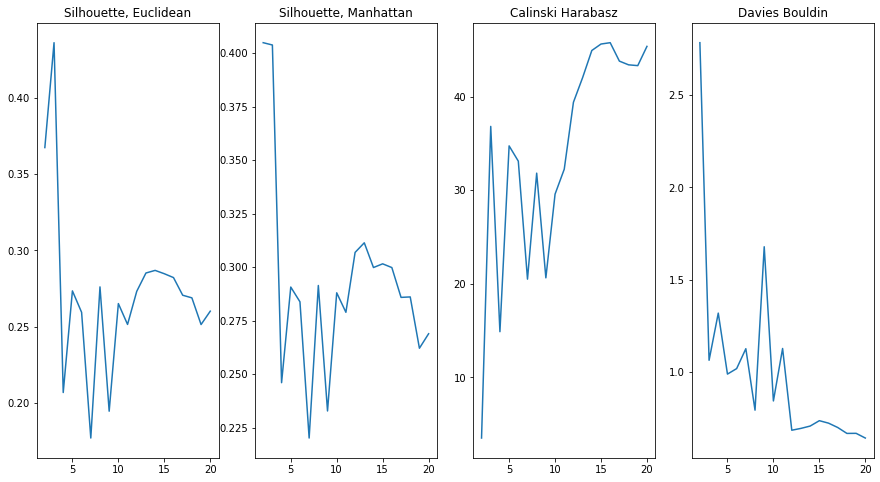



Number of principal components:  4


Silhouette Scores
Euclidean distance
Max:  0.3746 
 n_clusters:  3
Manhattan distance
Max:  0.3696 
 n_clusters:  2


Calinski_Harabasz Score
Max:  29.8686 
 n_clusters:  20


Davis Bouldin Score
Min:  0.6908 
 n_clusters:  18


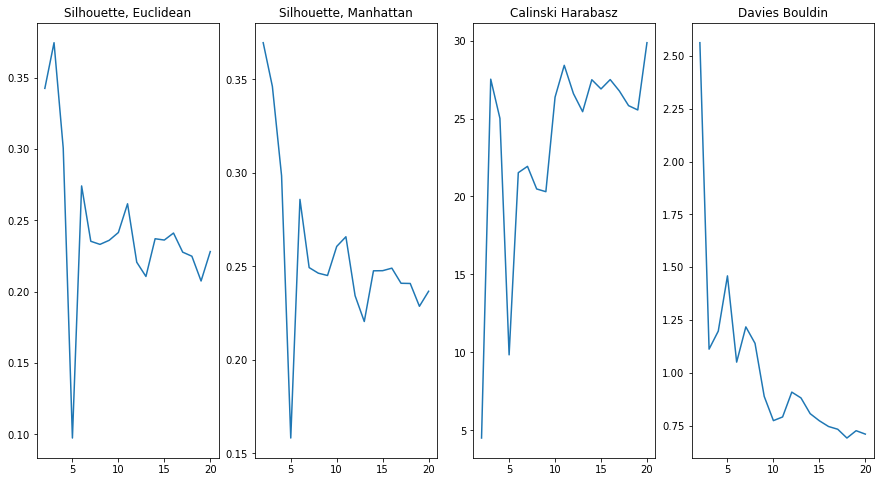



Number of principal components:  5


Silhouette Scores
Euclidean distance
Max:  0.3498 
 n_clusters:  3
Manhattan distance
Max:  0.3684 
 n_clusters:  2


Calinski_Harabasz Score
Max:  24.9668 
 n_clusters:  3


Davis Bouldin Score
Min:  0.6851 
 n_clusters:  19


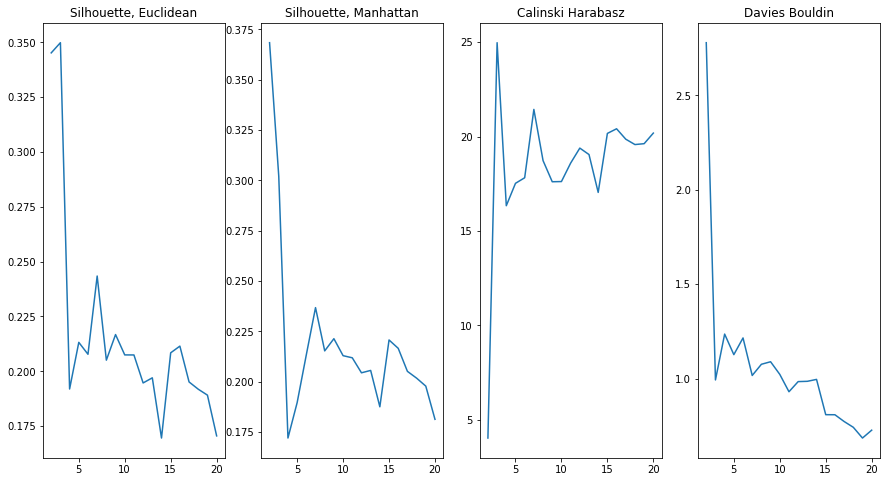



Number of principal components:  6


Silhouette Scores
Euclidean distance
Max:  0.301 
 n_clusters:  2
Manhattan distance
Max:  0.3308 
 n_clusters:  2


Calinski_Harabasz Score
Max:  17.5338 
 n_clusters:  5


Davis Bouldin Score
Min:  0.7368 
 n_clusters:  15


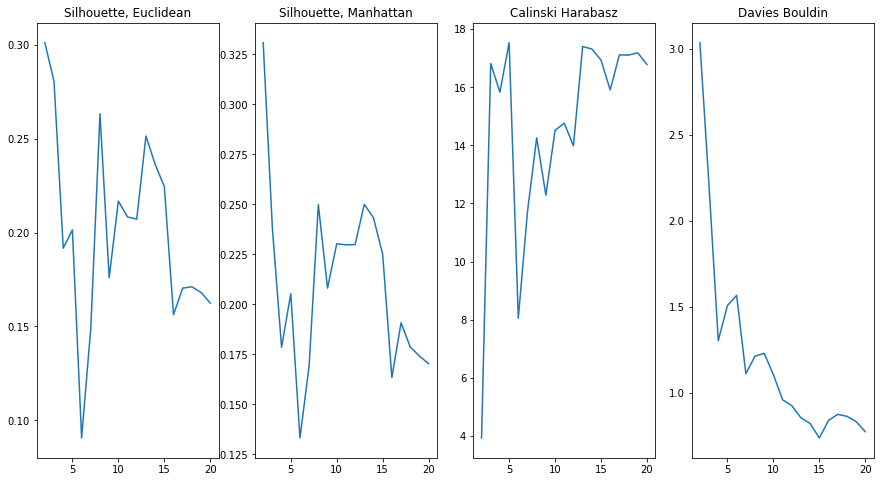



Number of principal components:  7


Silhouette Scores
Euclidean distance
Max:  0.3003 
 n_clusters:  2
Manhattan distance
Max:  0.3204 
 n_clusters:  2


Calinski_Harabasz Score
Max:  16.0133 
 n_clusters:  3


Davis Bouldin Score
Min:  0.7845 
 n_clusters:  20


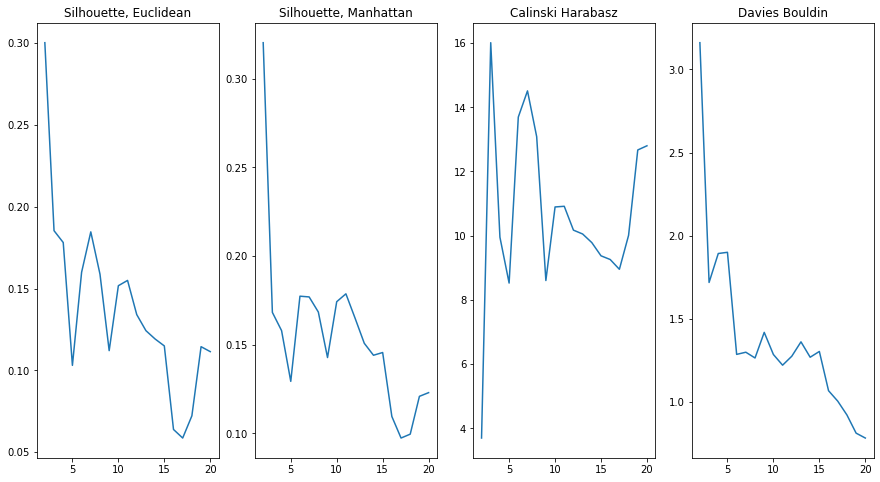



Number of principal components:  8


Silhouette Scores
Euclidean distance
Max:  0.2787 
 n_clusters:  2
Manhattan distance
Max:  0.291 
 n_clusters:  2


Calinski_Harabasz Score
Max:  11.6729 
 n_clusters:  9


Davis Bouldin Score
Min:  0.8564 
 n_clusters:  20


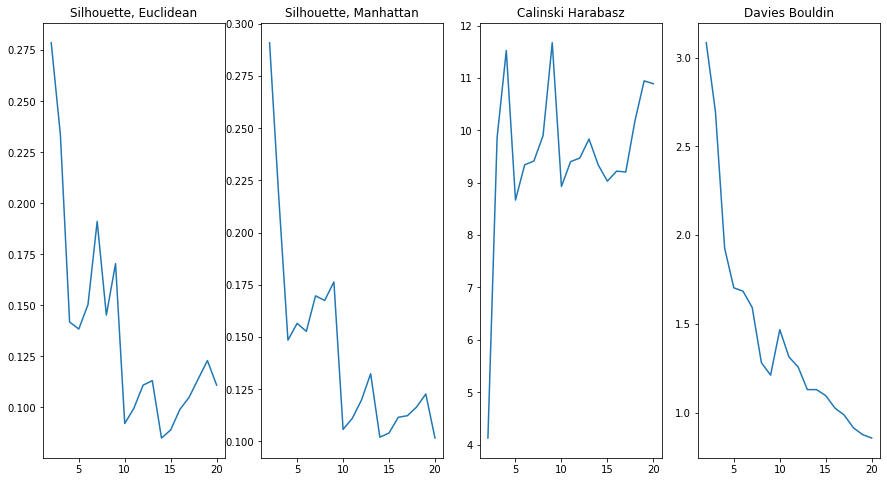



Number of principal components:  9


Silhouette Scores
Euclidean distance
Max:  0.2921 
 n_clusters:  2
Manhattan distance
Max:  0.3087 
 n_clusters:  2


Calinski_Harabasz Score
Max:  10.7747 
 n_clusters:  12


Davis Bouldin Score
Min:  0.8616 
 n_clusters:  20


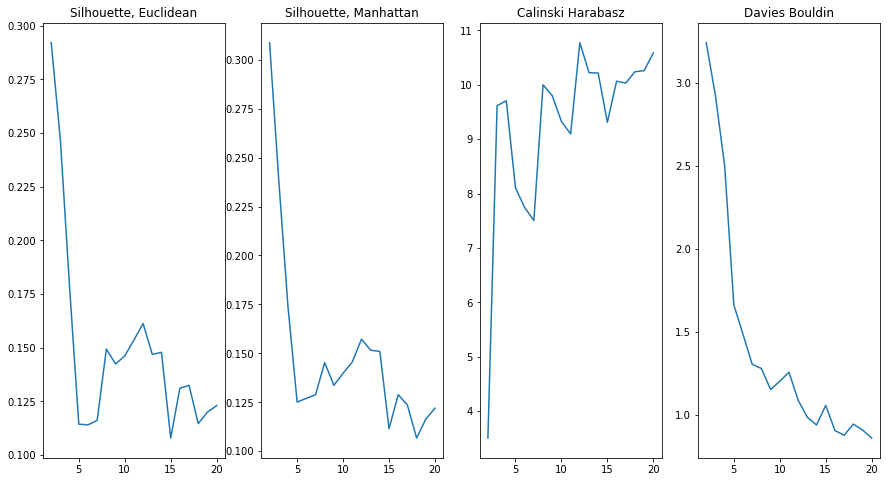



Number of principal components:  10


Silhouette Scores
Euclidean distance
Max:  0.2582 
 n_clusters:  2
Manhattan distance
Max:  0.2756 
 n_clusters:  2


Calinski_Harabasz Score
Max:  10.3285 
 n_clusters:  20


Davis Bouldin Score
Min:  0.8184 
 n_clusters:  20


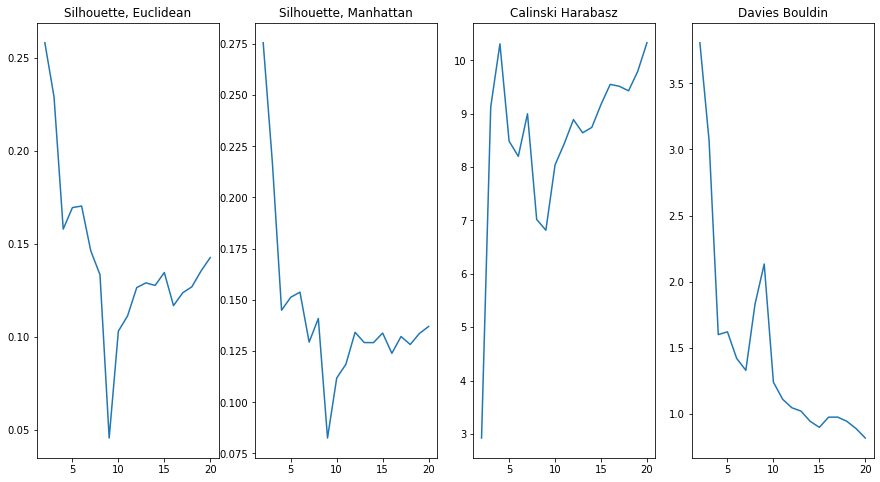

In [18]:
# Show diagnostics by number of principal components
for i in range(2, 11):
    print("Number of principal components: ", i)
    euc_list, man_list, ch_list, db_list = get_cluster_scores(
        n_components=i, n_clusters=20, ss_df=ss_df_post_rec, cluster_type="gmm")

    get_chart_diagnostics(euc_list, man_list, ch_list, db_list)
    print('\n')

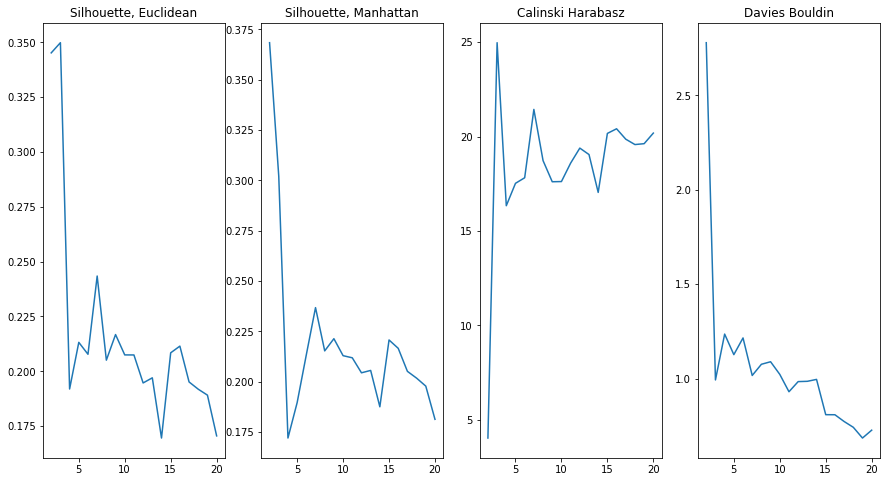

,euc_sil,man_sil,ch,db
2,0.345162,0.368363,4.036286,2.778235
3,0.349808,0.302047,24.966840,0.992687
4,0.191914,0.172053,16.335494,1.235434
5,0.213184,0.189618,17.521300,1.126637
6,0.207747,0.213417,17.815970,1.215094
7,0.243422,0.236807,21.434188,1.016302
8,0.205067,0.215330,18.723964,1.075645
9,0.216737,0.221380,17.604705,1.088989
10,0.207461,0.212948,17.614907,1.022142
11,0.207435,0.211893,18.590079,0.930196


In [19]:
# Review optimal clustering numbers using 5 principal components and gmm
euc_list, man_list, ch_list, db_list = get_cluster_scores(
    n_components=5, n_clusters=20, ss_df=ss_df_post_rec, cluster_type="gmm", print_diag=False)

get_chart_diagnostics(euc_list, man_list, ch_list, db_list)

pc5_scores = pd.DataFrame([euc_list, man_list, ch_list, db_list]).T
pc5_scores.columns = ["euc_sil", "man_sil", "ch", "db"]
new_index = pc5_scores.index.values + 2
pc5_scores = pc5_scores.set_index(new_index)
pc5_scores

For GMM pca = 5, n_clusters = 7 looks like a reasonable mix of metrics

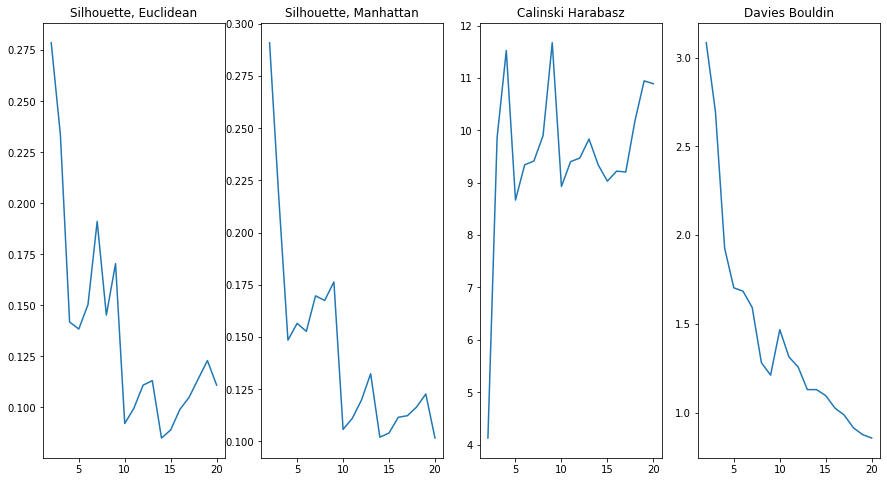

,euc_sil,man_sil,ch,db
2,0.278669,0.290997,4.126251,3.085013
3,0.233433,0.217109,9.863344,2.695529
4,0.141864,0.148540,11.522582,1.926668
5,0.138412,0.156579,8.668108,1.702986
6,0.150380,0.152727,9.342056,1.684070
7,0.191122,0.169753,9.413405,1.592358
8,0.145279,0.167552,9.897466,1.281151
9,0.170455,0.176421,11.672905,1.211108
10,0.092136,0.105772,8.928486,1.467478
11,0.099701,0.111061,9.402486,1.313314


In [20]:
# Review optimal clustering numbers using 5 principal components and gmm
euc_list, man_list, ch_list, db_list = get_cluster_scores(
    n_components=8, n_clusters=20, ss_df=ss_df_post_rec, cluster_type="gmm", print_diag=False)

get_chart_diagnostics(euc_list, man_list, ch_list, db_list)

pc8_scores = pd.DataFrame([euc_list, man_list, ch_list, db_list]).T
pc8_scores.columns = ["euc_sil", "man_sil", "ch", "db"]
new_index = pc8_scores.index.values + 2
pc8_scores = pc8_scores.set_index(new_index)
pc8_scores

**Observations:** <br>
Higher db scores for all. Use n_cluster = 9 for pca=8 for GMM

Seems like making a final decision on number of clusters and PCA is somewhat subjective, since different scores indicate different clustering success. For my purposes, I will continue with a Kmeans 7 and GMM 7 with PCA = 5.

Feedback: how much explained variance is "enough" in this sort of analysis? How better to think about trade offs in clustering scores & cumulative explained variance?

### Define reduced (with PCA) df that will be used in clustering algorithms & clean it

In [21]:
# Instantiate reduced_df and reduced_df_post_rec with correct number of Kmeans and
# GMM clusters
reduced_df = get_reduced_df(ss_df, n_components=5, k_clusters=7, 
                            gmm_clusters=7, max_iter=10000)

reduced_df_post_rec = get_reduced_df(ss_df_post_rec, n_components=5, k_clusters=7, 
                                     gmm_clusters=7, max_iter=10000)

reduced_df_post_rec.rename({"Dallas_Plano_Irving_TX": "Dallas_TX",
                  "Denver_Aurora_Lakewood_CO": "Denver_CO",
                           "Porland_ME": "Portland_ME",
                           "Porland_Vancouver_Hillsboro_OR_WA": "Portland_OR",
                           "Sacramento_Roseville_Folsom_CA": "Sacramento_CA"}, inplace=True)

# K-means

**What is K-means?**<br>
K-means is an iterative approach to cluster unstructured (i.e. unlabeled) data. It works by randomly initiating centroids - that is, centers of the clusters - then finding the variance of the distances from each point in a cluster to the centroid of the cluster. This variance is then minimized by reclassifying observations to different clusters based on their distance to that cluster's centroid (ie the mean of the cluster), and then moving the centroid to minimize the mean values. This iterative process continues until the categories remain unchanged, or some threshold is reached. 
<br><br>

Formally, let $d(x_i, x_i')$ be some distance metric. $d(x_i, x_i')$ is notationally equivalent to $d_{i,i'}$, so $d(x_i, x_i') = d_{i,i'}$

The distance metric $d_{i, i'}$ can take different forms. Two popular distance metrics are Euclidean and Manhattan:

**Euclidean:** $d(x_i, x_i') = \sum_{j=1}^{p} (x_{i, j} - x_{i', j})^2   = ||x_i - x_{i'}||^2$

**Manhattan:** $d(x_i, x_i') = \sum_{j=1}^{p} |{x_{i, j} - x_{i', j}|}$

When assigning observations to clusters with K-means, we can use the concept of *within-cluster point scatter* to better categorize objects. In order to define the within-cluster point scatter, or $W(C)$, we first need to define an encoder function $C(i)$ that assigns each observations $i$ to some cluster $k$. An encoder function is sort of like a function (and has the same notation as a function), in that it takes inputs and returns an output. However, unlike a function, each input observation $i$ is mapped explicitly to an output cluster by the encoder. 

With our encoder function $C(i)$, we can represent the $W(C)$ as:
<br><br>
$W(C) = \sum_{k=1}^{K} \sum_{C(i)=k} \sum_{C(i') \ne k} d(x_i, x_{i'})$

Here, $k = \{1...K\}$ is the set of cluster labels. $\sum_{C(i) = k}$ sums the distances between all $i$ points in cluster $k$ and the centroid of cluster $k$. The next term,  $\sum_{C(i') \ne k}$, excludes  all observations $i'$ that are not in category $k$. 

Using Euclidean distances, we can rewrite $W(C)$ as:<br>
$$
\begin{align}
W(C) = \sum_{k=1}^{K} \sum_{C(i)=k} \sum_{C(i') \ne k} d(x_i, d_{xi'}) \\
& = \sum_{k=1}^{K} \sum_{C(i)=k} \sum_{C(i') \ne k} \sum_{j=1}^{p}(x_{i, j} - x_{i', j})^2 \\
& = \sum_{k=1}^{K} \sum_{C(i)=k} \sum_{C(i') \ne k} ||x_i - x_{i'}||^2
\end{align}
$$
The notation $||x_i - x_{i'}||^2$ is shorthand for the Euclidean norm or Euclidean distance. <br>
Next, let $\bar{x}_k$ be the mean vector $(\bar{x}_{1, k}, ..., \bar{x}_{p, k})$ for cluster k. Let $N_k$ be the total number of observations $N$ that must be assigned to k different clusters with our K-means algorithm. Using this notation, we can rewrite $W(C)$ as:

$$
W(C) = \sum_{k=1}^{K} N_k \sum_{C(i)=k} ||x_i - \bar{x}_k||^2
$$

In the above equation, $\sum_{C(i)=k} ||x_i - \bar{x}_k||^2$ sums the distances for cluster k, and $\sum_{k=1}^{K} N_k$ loops through all of the clusters. 
<br><br>
Recall that $C(i)$ is the encoding function that we seek to vary through an iterative process to minimize our within-cluster variance. So, let $C^{*}(i)$ be the encoding function that minimizes $W(C)$, or the within-cluster variance. The objective function of our algorithm can then be restated as:
<br><br>
$C^{*}(i) = min_{C(i)} \sum_{k=1}^{K} N_k \sum_{C(i)=k} ||x_i - \bar{x}_k||^2$
<br><br>
Rewrite $\bar{x}_k$ as $m_k$, representing a mean that is a constant value for each category K. Then:
<br><br>
$C^{*}(i) = min_{C(i)} \sum_{k=1}^{K} N_k \sum_{C(i)=k} ||x_i - m_k||^2$

This allows us to take the derivative with respect to $\{m_1,...,m_k\}$, which occurs in Step 2 of the distance minimizing algorithm that follows. The iterative algorithm to minimize our cost function works as follows: 
<br><br>
### K-means minimization algorithm
<ol>
    <p>1) Randomly initialize centroids and the assignments of each observation to some cluster $k$.</p>
    <p>2) Minimize within-cluster variance with respect to $\{m_1,...,m_k\}$. This yields the new means, $m_k$, for each group $k$.</p> 
    <p>3) Now that new means have been calculated, minimize $C^{*}(i)$ again by reassigning each observtion $i$ to the closest cluster mean. Formally:
<br><br>
$C(i) = argmin_{1 \le k \le K} ||x_i - m_k||^2$
        
This equation can be interpreted as: select a cluster $k$ (from a total number of $K$ clusters) that results in an encoding function $C(i)$ with the lowest value for $||x_i - m_k||^2$. Repeat this iterative procedure until there are no further changes in cluster assignments, or the threshold of maximum iterations has been reached.</ol>

<br><br>
*See: "Elements of Statistical Learning, The", Hastie, Tibshirani, Friedman, pp. 507-510 for more detail.*


### Plot K-means clusters

To get a sense of which cities may be close to experiencing the sort of explosive growth in housing prices seen in Austin over the last decade, I review: <ol>
    <p>1) a cluster of Austin's housing prices with other cities over the same time period </p>
    <p>2) a cluster plot of Austin's housing prices with other cities, with Austin's housing prices lagged by 6 years and </p>
    <p> 3) a cluster plot of Austin's housing prices with other cities, with Austin's housing prices lagged by 7 years and</ol>
        
Note that the groups are clustered by housing price index *growth*, so what's being compared it a stationary series of growth, rather than the nonstationary index series itself.

Graphic note: While the cluster images below seem very small in the python notebook, it can be more easily interacted with after exporting to a .png file. This is an artifact of the image needed to be sufficiently large so that the text labels for each data point don't overlap.

In [22]:
# Define a list of colors that will be used throughout to maintain 
# color consistency .
color_list = ["blue", "orange", "green", "red", "purple", "brown", "pink"]

#### K-means lag 0 (that is, comparison for non-lagged series of Austin)

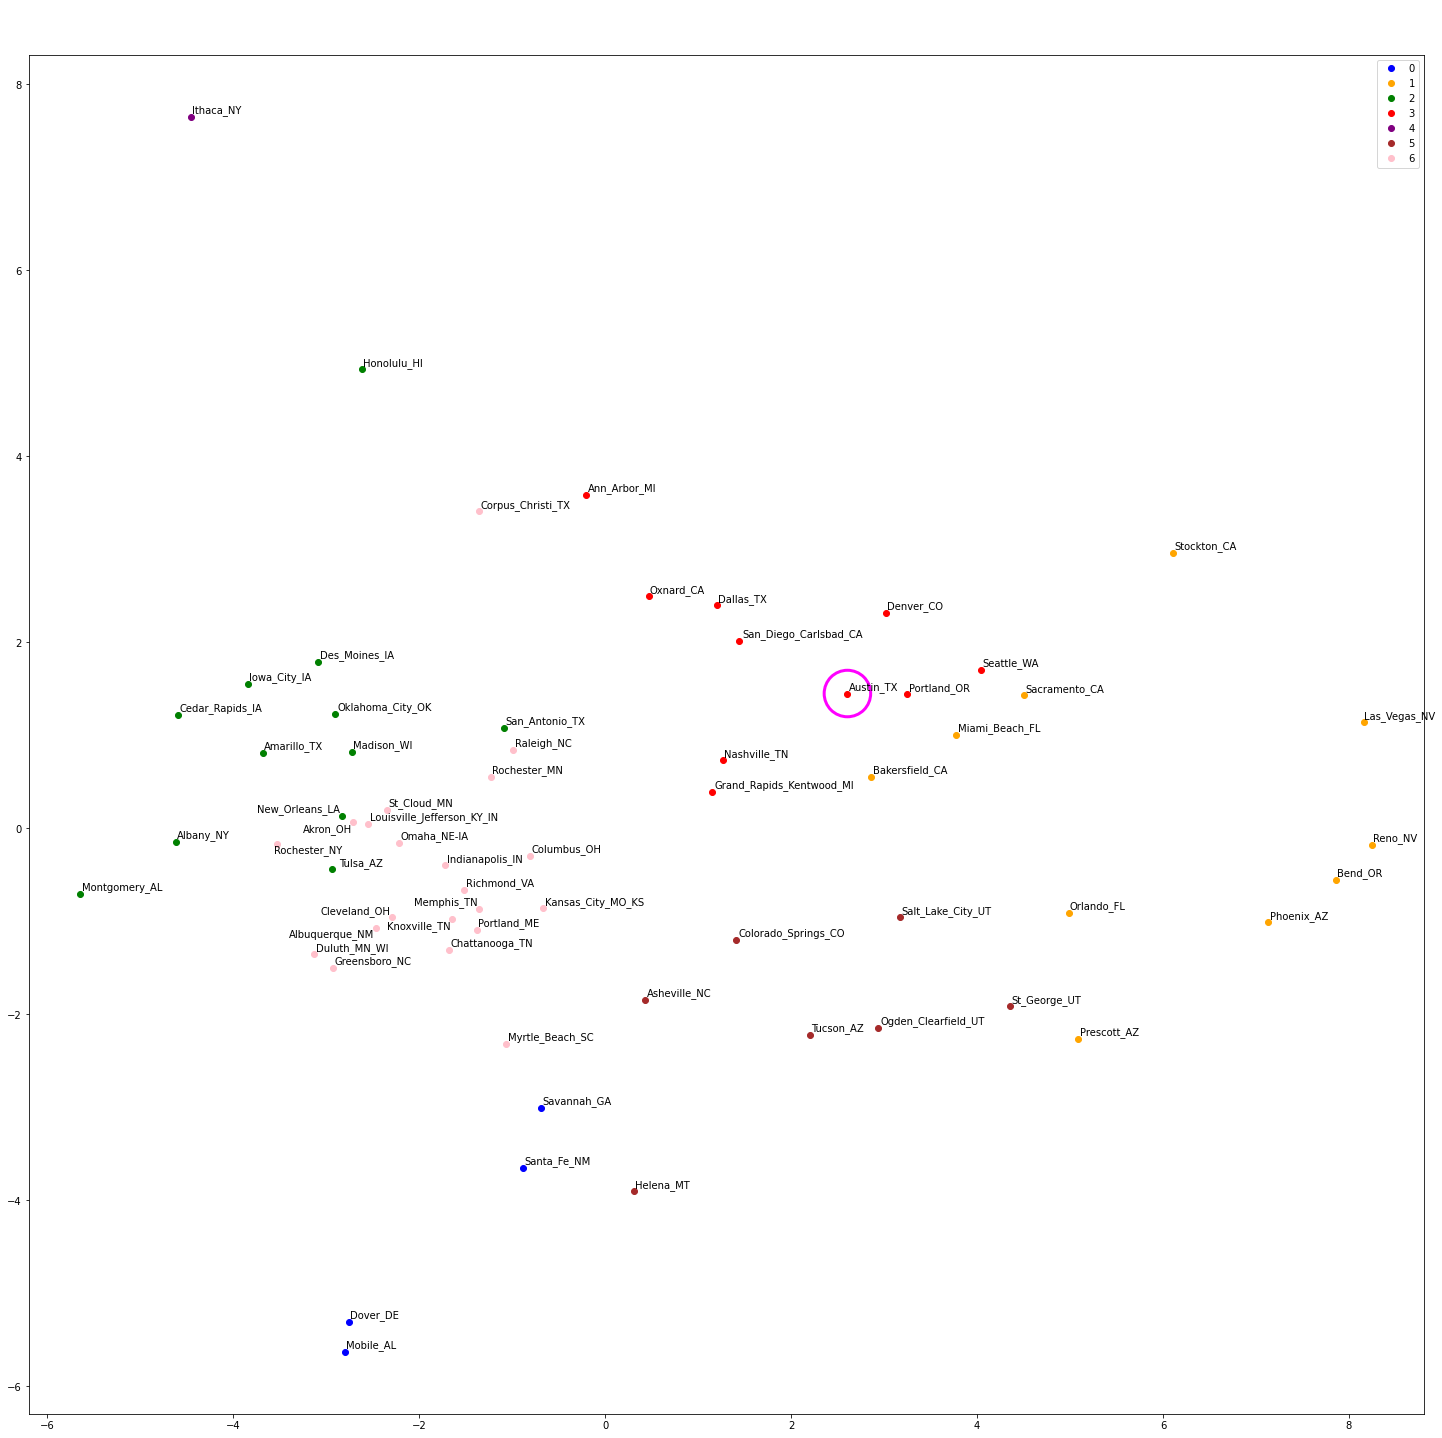

In [23]:
# K-means Lag 0
plot_clusters(reduced_df_post_rec, cluster_type="kmeans_group", 
              adjust_text_on=True, radius=0.25, color_list=color_list)

plt.savefig('kmeans_lag0.png')

#### Future improvement
Note: technically could rerun Cluster scores (Silhouette, CH, DB) here for the PCA transform of the lagged matrix. After lagging the Austin housing price index, the analysis to determine optimal PCA components & clusters may be slightly different, but not much as the only city changing would be Austin

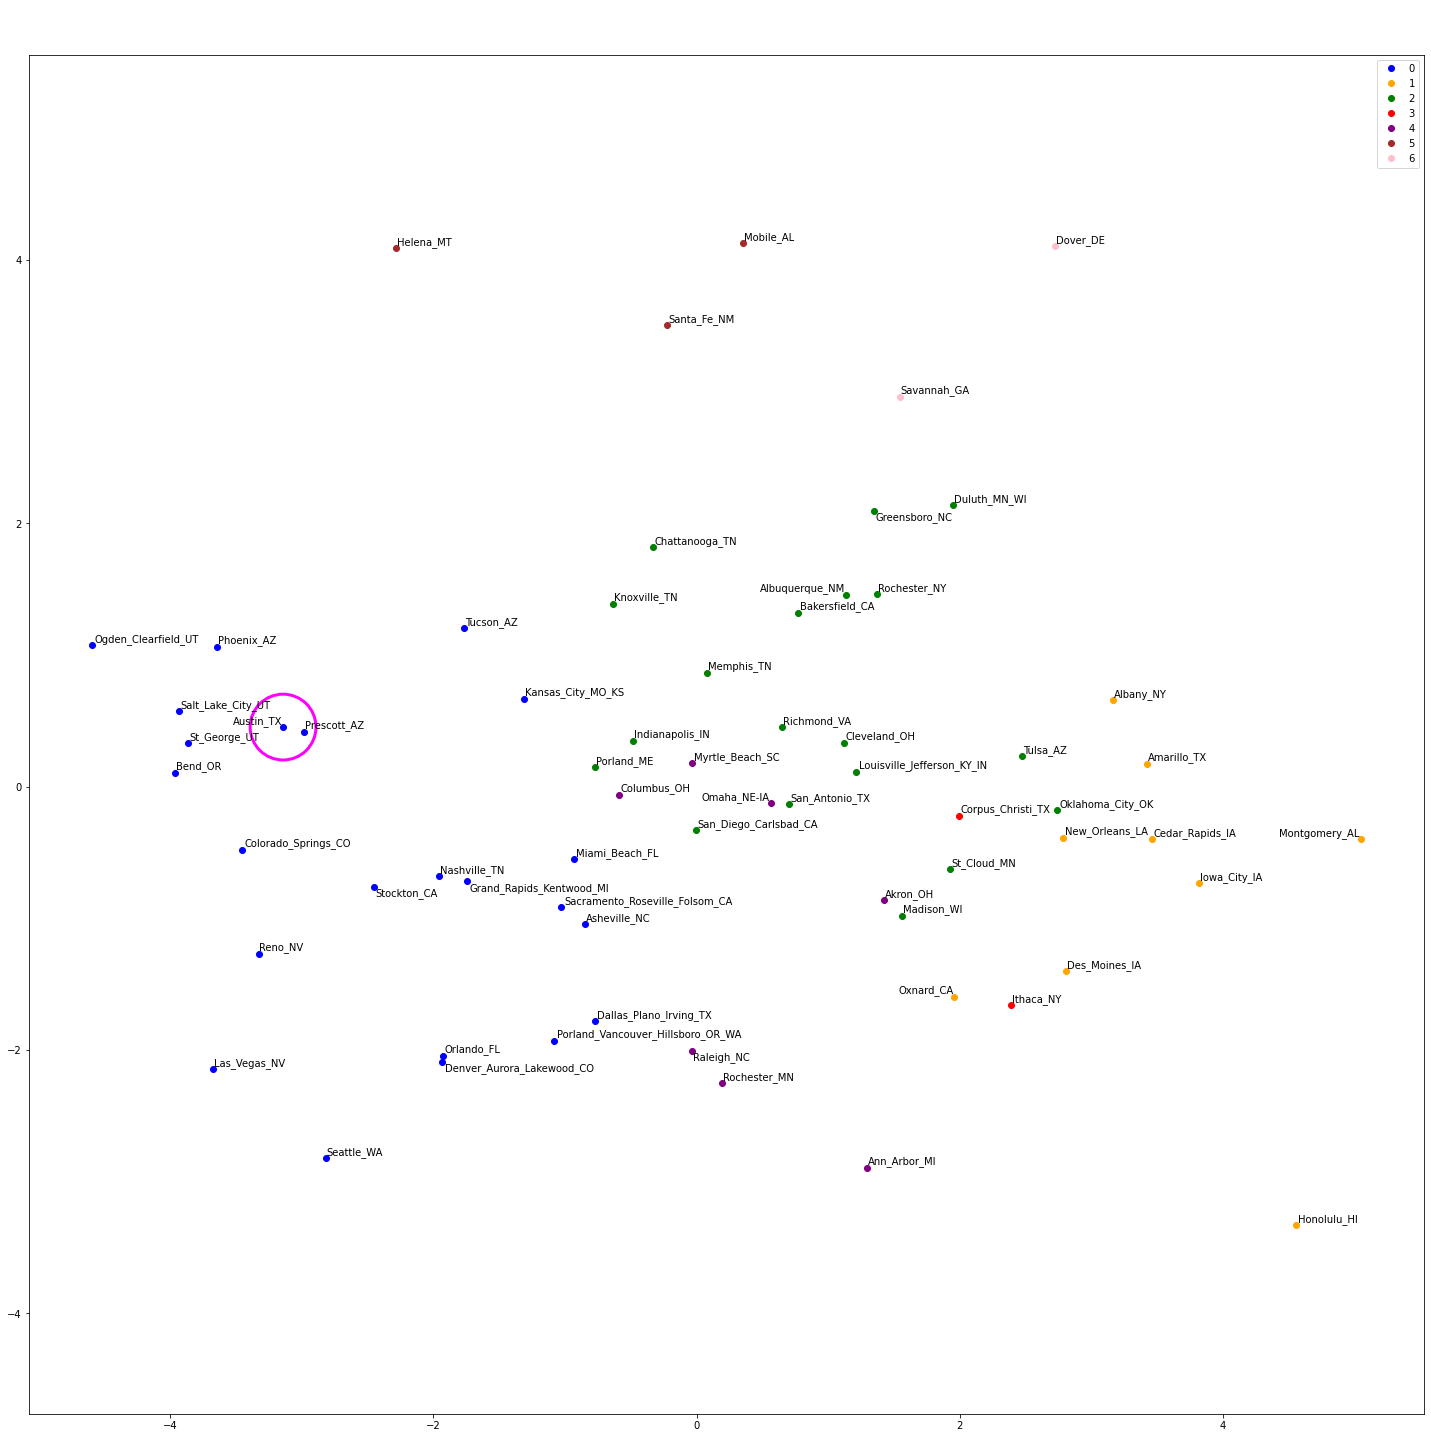

In [24]:
# Kmeans lag 6
lag6_df_post_rec = get_lagged_df(ss_df_post_rec, lead_quarters=24)
lag6_df_reduced_post_rec = get_reduced_df(lag6_df_post_rec, n_components=5, 
                                         k_clusters = 7, gmm_clusters = 7)

plot_clusters(lag6_df_reduced_post_rec, cluster_type="kmeans_group", 
              adjust_text_on=True, radius=0.25, color_list=color_list)

plt.savefig('kmeans_lag6.png')

#### K-means lag 7 for Austin

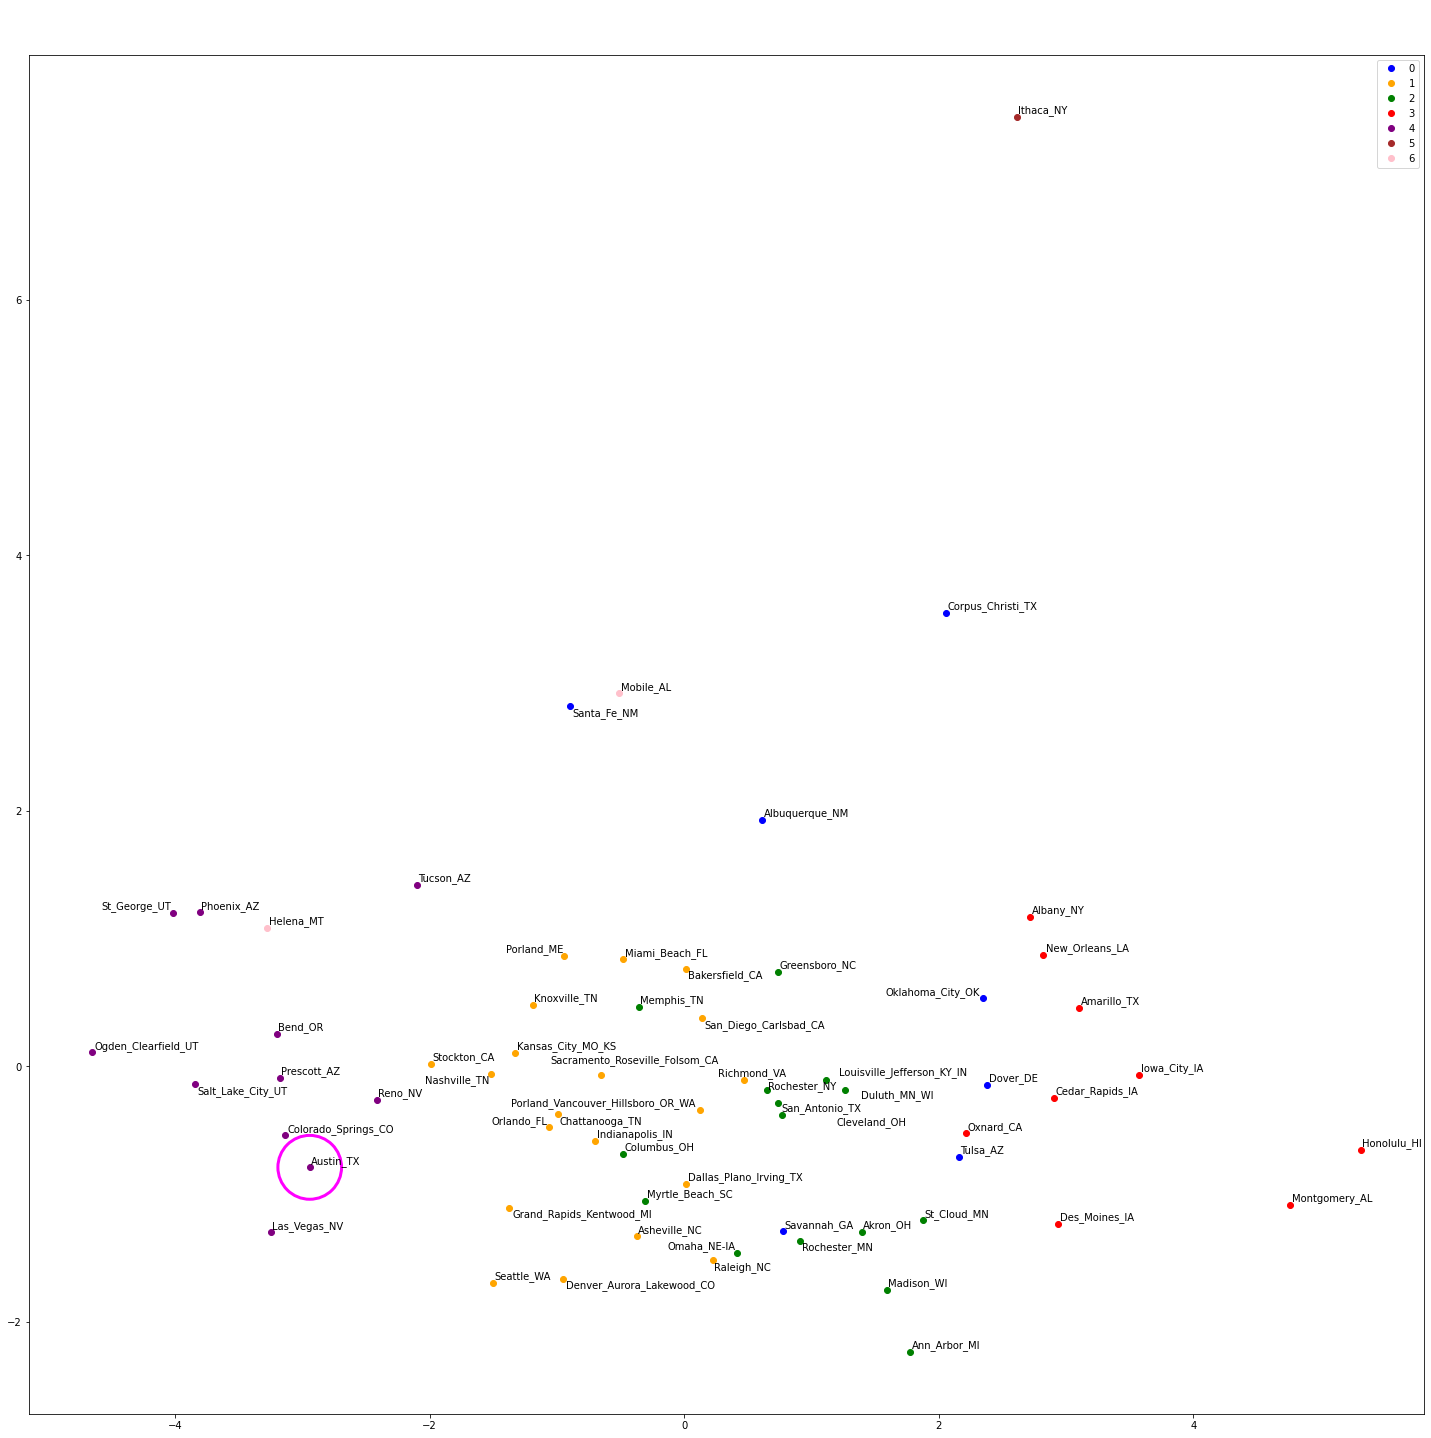

In [25]:
# Kmeans lag 7
lag7_df_post_rec = get_lagged_df(ss_df_post_rec, lead_quarters=28)
lag7_df_reduced_post_rec = get_reduced_df(lag7_df_post_rec, n_components=5,
                                         k_clusters = 7, gmm_clusters = 7)

plot_clusters(lag7_df_reduced_post_rec, cluster_type="kmeans_group", 
              adjust_text_on=True, radius=0.25, color_list=color_list)

plt.savefig('kmeans_lag7.png')

# Gaussian Mixture Model clusters

One of the drawbacks of K-means clusters is that the clusters are circular or hyper-circular. That is, if looking at a 2D cluster like above, the clusters would all be defined by the distance of some radius. This can be somewhat limiting, as there may be non-circular patterns that are useful in improving the clustering algorithm. 

Gaussian Mixture Models (GMM) are one improvement upon K-means. Rather than being stuck with hypercircles, GMMs allow for more flexibile shapes to be used in the clustering (like ellipses). GMMs are defined by a centroid and a covariance matrix, with the covarince matrix determining the shape of the ellipse. This flexibility is often why GMMs are referred to as "soft" clustering, where as K-means are referred to as "hard" clustering.

### Plot Gaussian Mixture Model clusters

#### GMM Lag 0

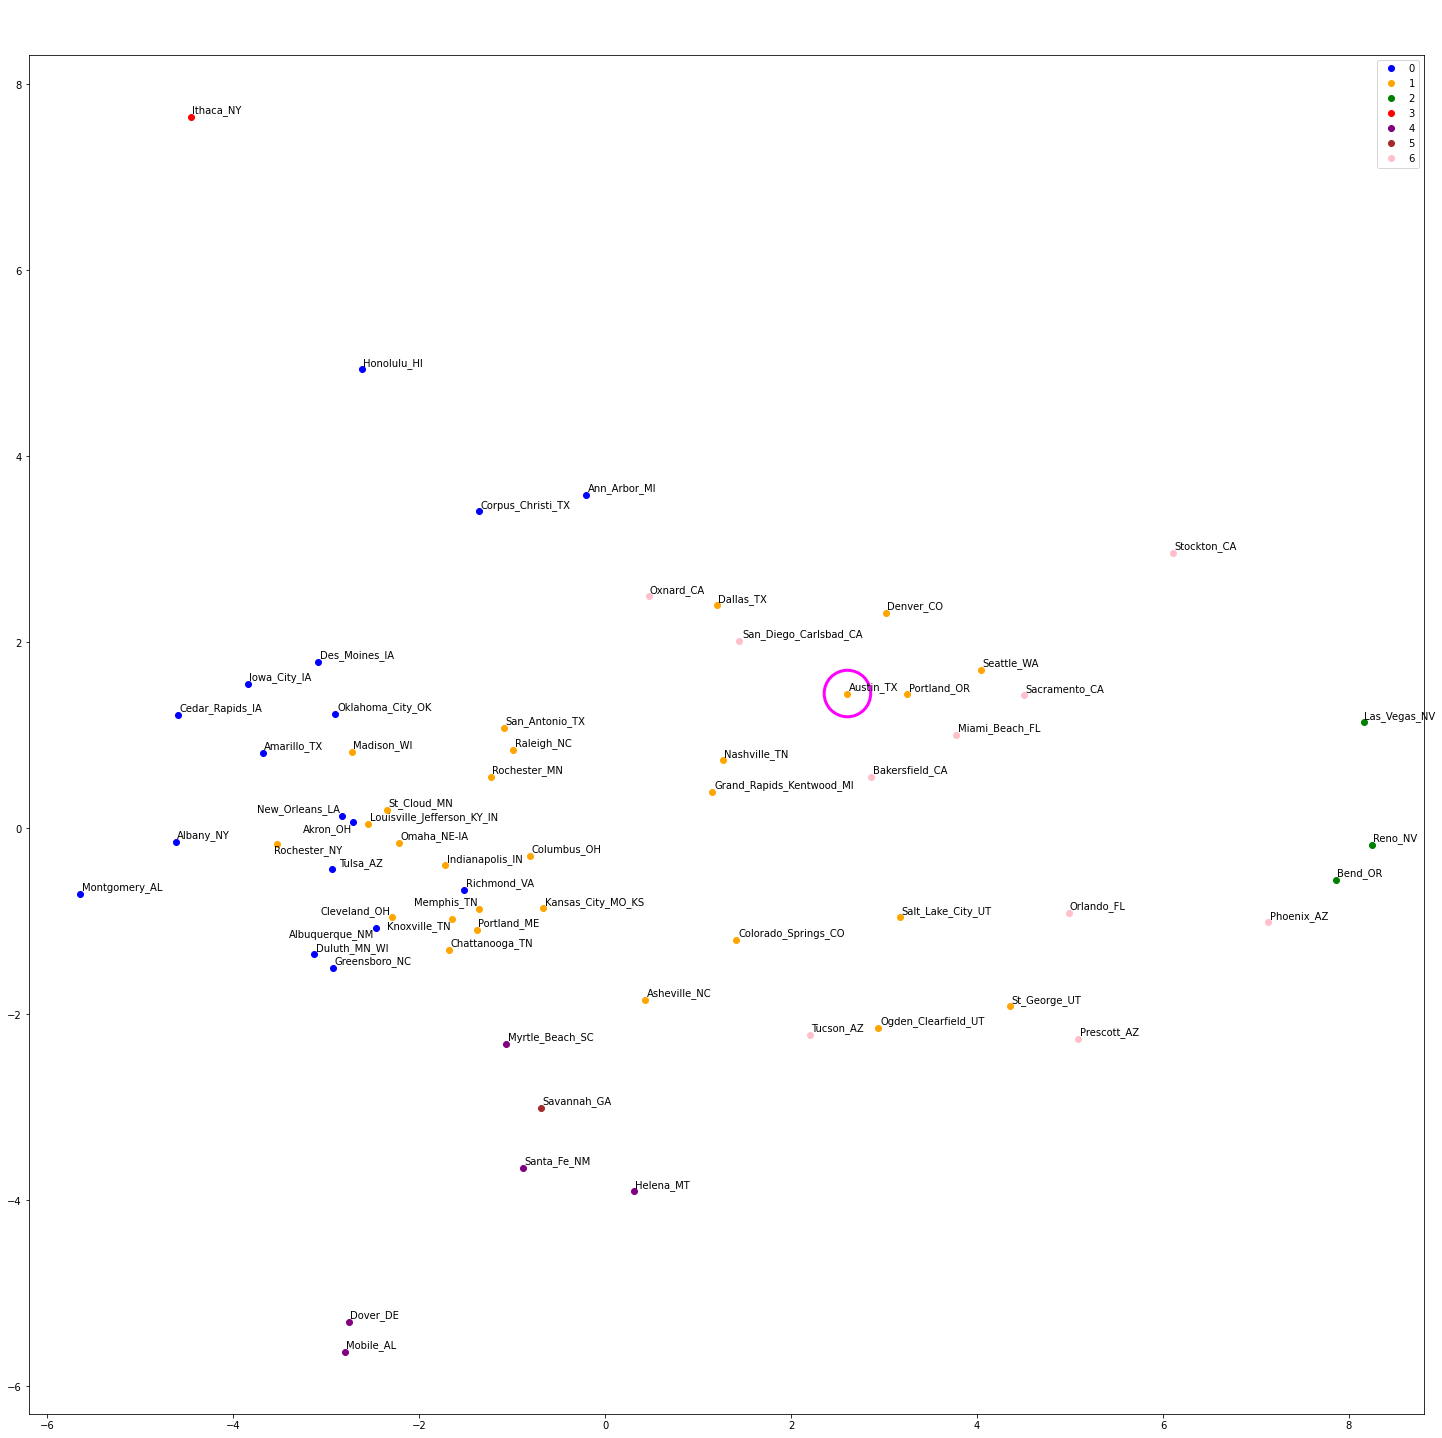

In [26]:
# GMM Lag 0
plot_clusters(reduced_df_post_rec, cluster_type="gmm_group", 
              adjust_text_on=True, radius=0.25, color_list=color_list)

plt.savefig('gmm_lag0.png')

#### GMM lag 6

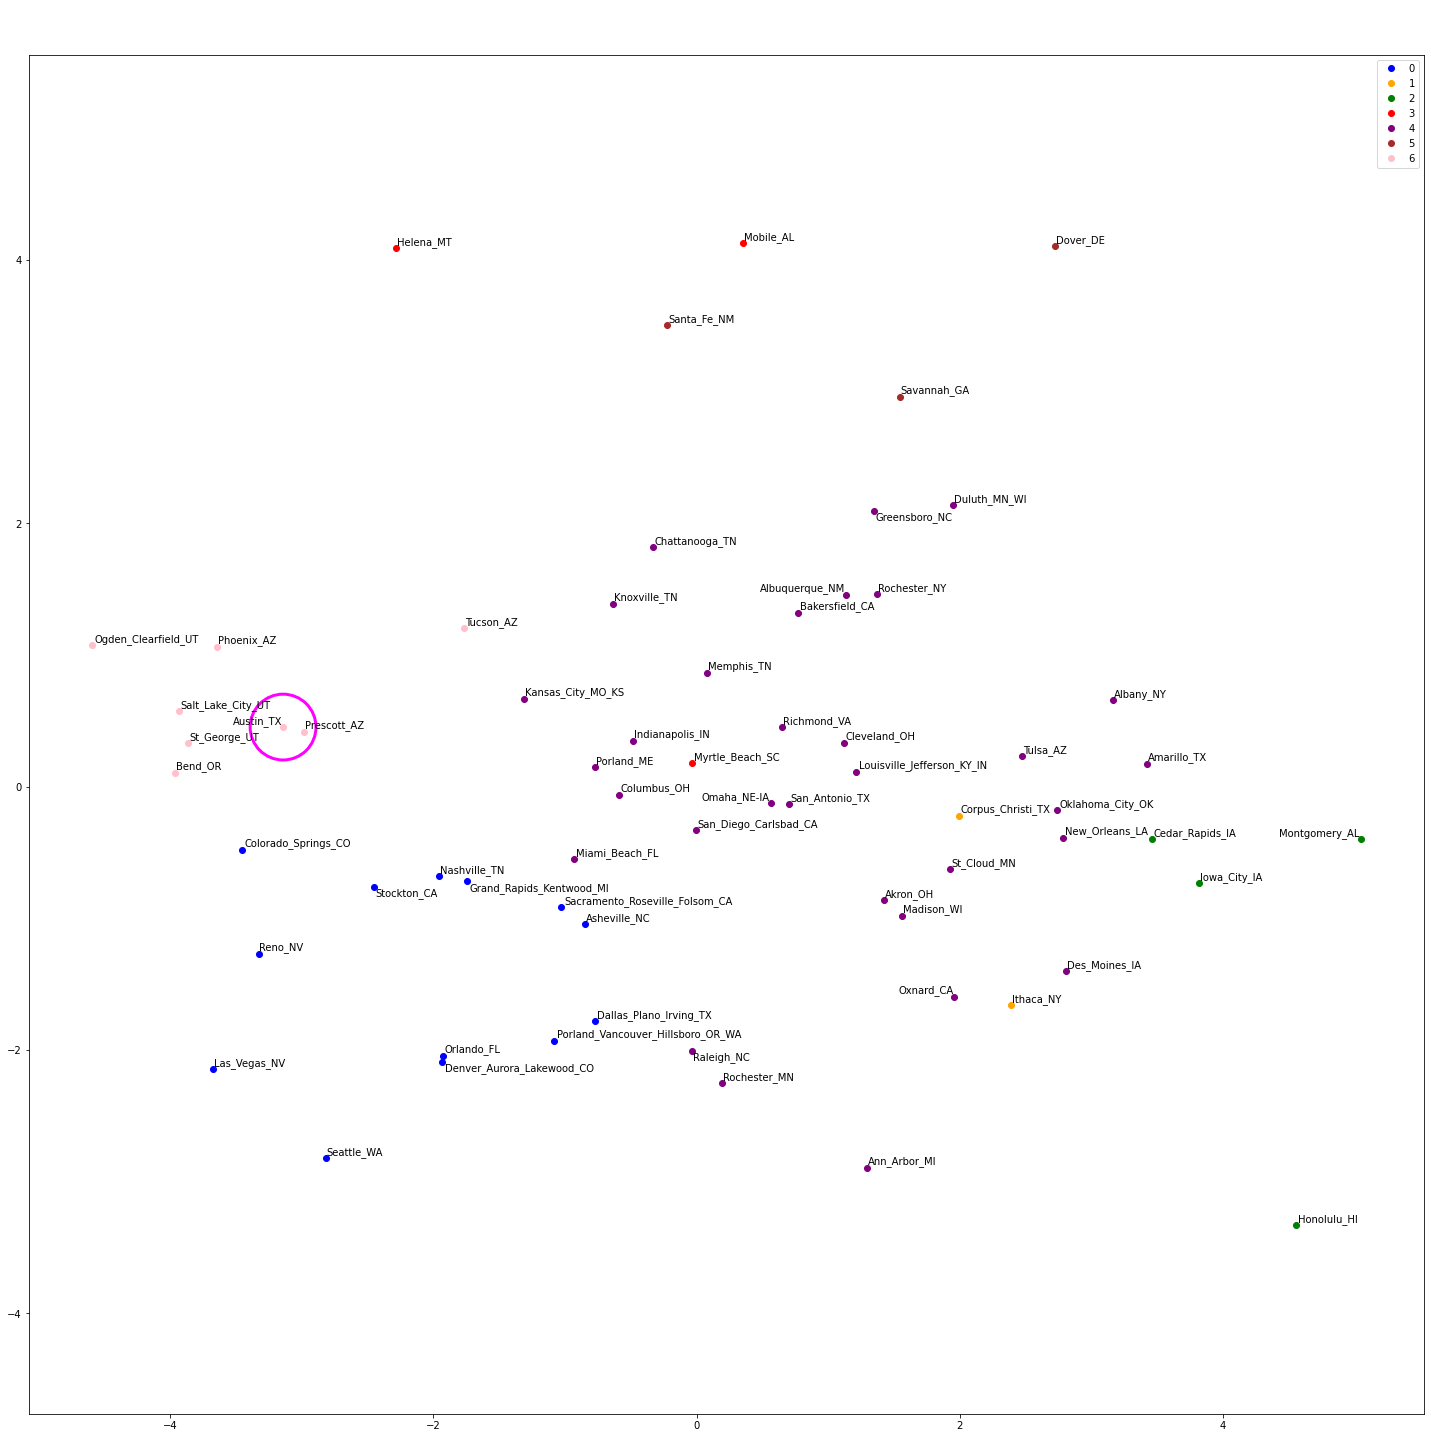

In [27]:
# Gmm lag 6
lag6_df_post_rec = get_lagged_df(ss_df_post_rec, lead_quarters=24)
lag6_df_reduced_post_rec = get_reduced_df(lag6_df_post_rec, n_components=5, 
                                          k_clusters = 7, gmm_clusters = 7,
                                          max_iter=10000)

plot_clusters(lag6_df_reduced_post_rec, cluster_type="gmm_group", 
              adjust_text_on=True, radius=0.25, color_list=color_list)

plt.savefig('gmm_lag6.png')

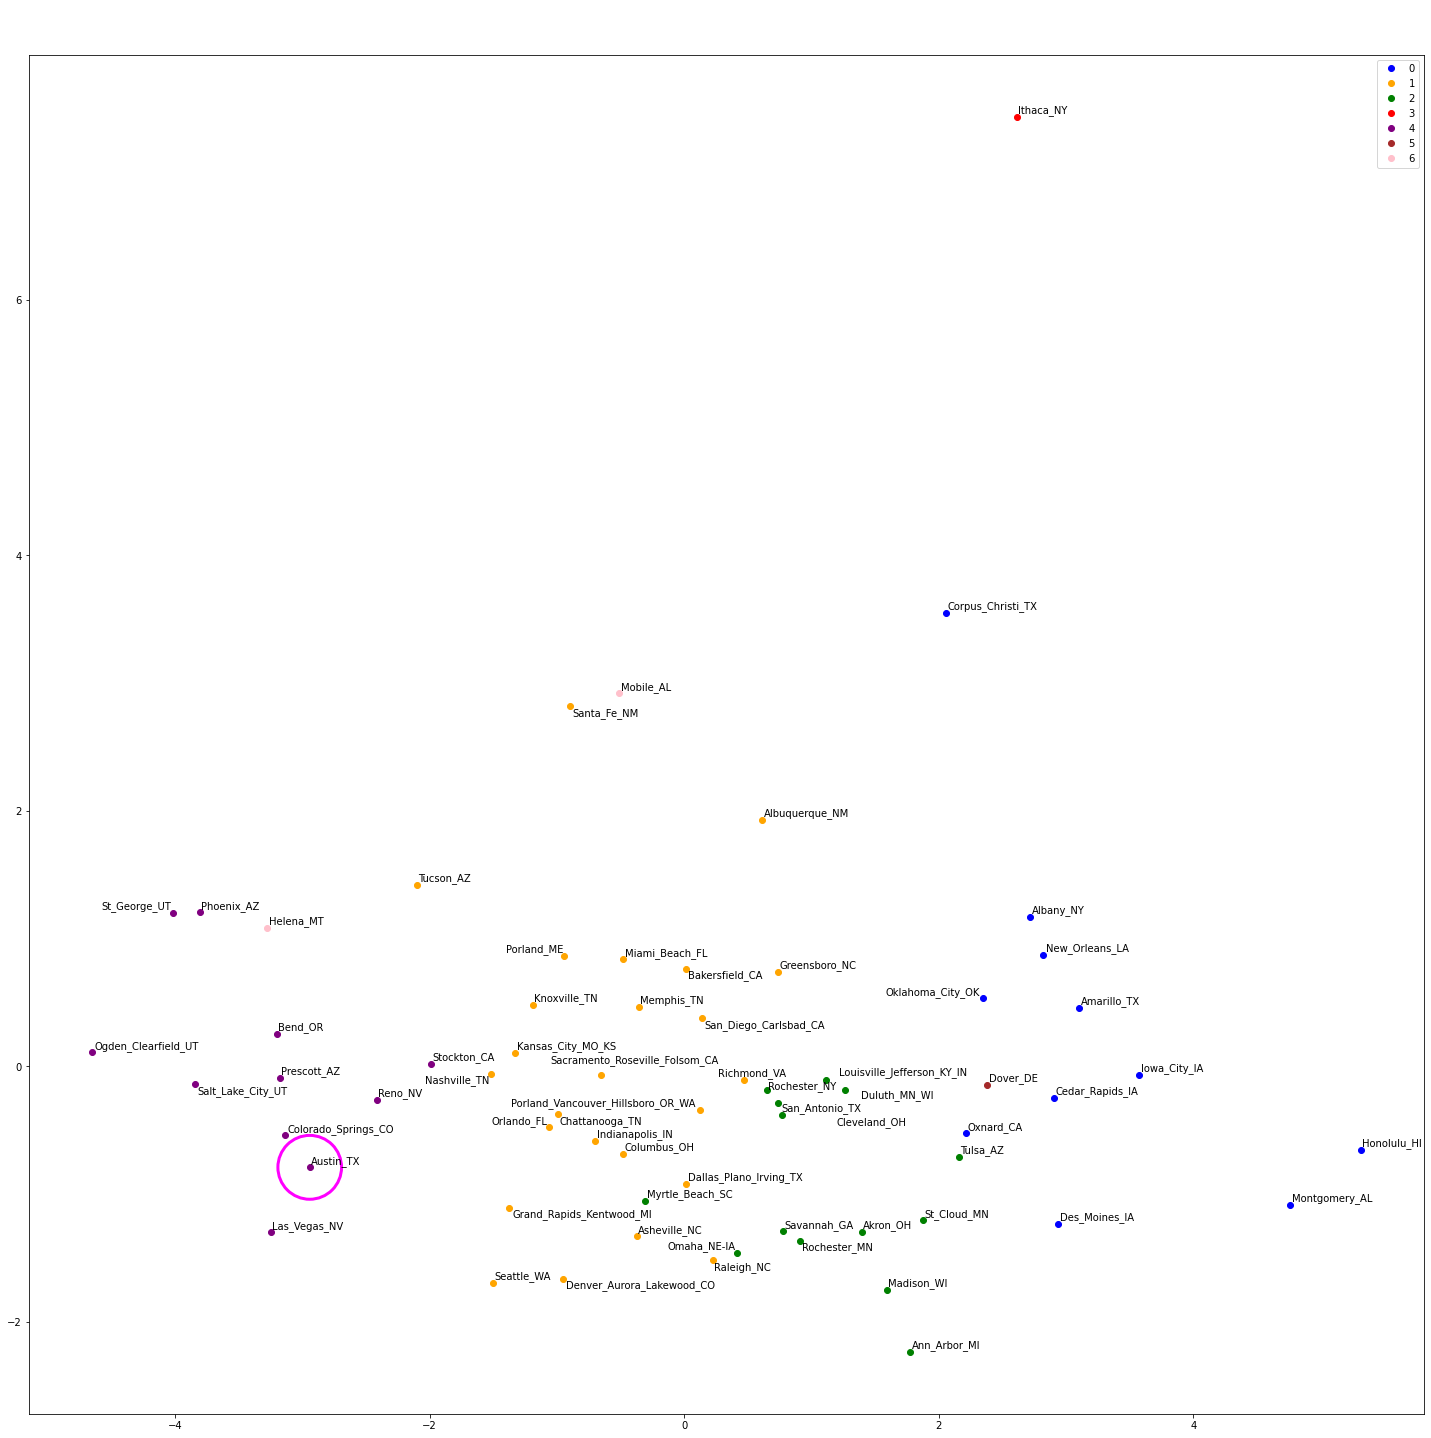

In [28]:
# Gmm lag 7
lag7_df_post_rec = get_lagged_df(ss_df_post_rec, lead_quarters=28)
lag7_df_reduced_post_rec = get_reduced_df(lag7_df_post_rec, n_components=5, 
                                          k_clusters = 7, gmm_clusters = 7,
                                          max_iter=10000)

plot_clusters(lag7_df_reduced_post_rec, cluster_type="gmm_group", 
              adjust_text_on=True, radius=0.25, color_list=color_list)

plt.savefig('gmm_lag7.png')

# Explore data in 3D
Should we choose K-means or GMM? Looking at the data in 3D may inform this decision, since a meaningful amount of information is lost when this data is presented in 2D (that is, all the data explained by the 3rd principal component). Only ~34% of variance is explained with the first two principal components (see above). Adding the third principal component increases explained variance to ~42%, which represents a 26% increase in explained variance. For this reason, it may well be worth exploring the data in 3D, where we can see the third principal component plotted along the z axis.

<IPython.core.display.Javascript object>


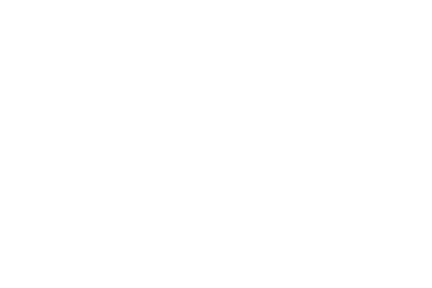

In [29]:
# Lag 0, investigate data in 3D
# matplotlib notebook is necessary for 3D interactivity
%matplotlib notebook
ax = plt.axes(projection = '3d')

xdata = reduced_df_post_rec.iloc[:, 0]
ydata = reduced_df_post_rec.iloc[:, 1]
zdata = reduced_df_post_rec.iloc[:, 2]

colors = ["mistyrose", "lightsteelblue", "violet", "green", "red", "black"]
ax.scatter3D(xdata, ydata, zdata, c = reduced_df_post_rec['gmm_group'], alpha = 0.8)
# ax.scatter3D(xdata, ydata, zdata, c = reduced_df_post_rec['kmeans_group'], alpha = 0.8)
plt.show()

<IPython.core.display.Javascript object>


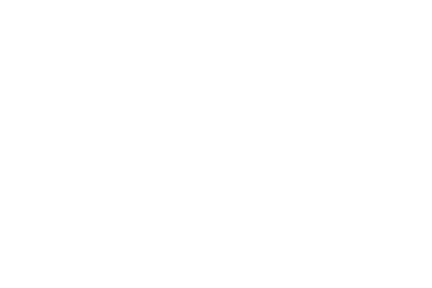

In [30]:
# Lag 6, Kmeans
%matplotlib notebook
ax = plt.axes(projection = '3d')

xdata = lag6_df_reduced_post_rec.iloc[:, 0]
ydata = lag6_df_reduced_post_rec.iloc[:, 1]
zdata = lag6_df_reduced_post_rec.iloc[:, 2]

colors = ["mistyrose", "lightsteelblue", "violet", "green", "red", "black"]
ax.scatter3D(xdata, ydata, zdata, c = lag6_df_reduced_post_rec['kmeans_group'], alpha = 0.8)
plt.show()

<IPython.core.display.Javascript object>


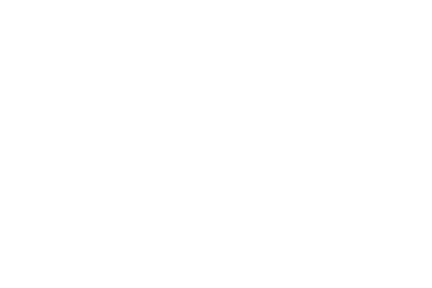

In [31]:
# Lag 6, GMM
%matplotlib notebook
ax = plt.axes(projection = '3d')

xdata = lag6_df_reduced_post_rec.iloc[:, 0]
ydata = lag6_df_reduced_post_rec.iloc[:, 1]
zdata = lag6_df_reduced_post_rec.iloc[:, 2]

colors = ["mistyrose", "lightsteelblue", "violet", "green", "red", "black"]
ax.scatter3D(xdata, ydata, zdata, c = lag6_df_reduced_post_rec['gmm_group'], alpha = 0.8)
plt.show()

<IPython.core.display.Javascript object>


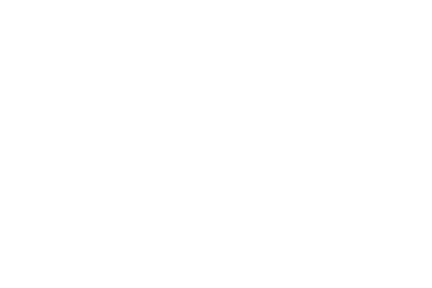

In [32]:
# Lag 7, Means
%matplotlib notebook
ax = plt.axes(projection = '3d')

xdata = lag7_df_reduced_post_rec.iloc[:, 0]
ydata = lag7_df_reduced_post_rec.iloc[:, 1]
zdata = lag7_df_reduced_post_rec.iloc[:, 2]

colors = ["mistyrose", "lightsteelblue", "violet", "green", "red", "black"]
ax.scatter3D(xdata, ydata, zdata, c = lag7_df_reduced_post_rec['kmeans_group'], alpha = 0.8)
plt.show()

<IPython.core.display.Javascript object>


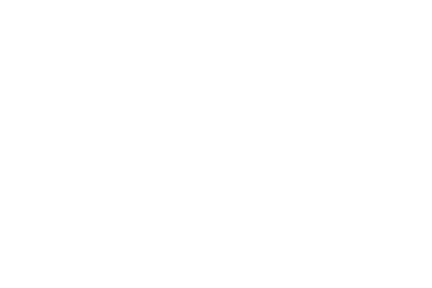

In [33]:
# Lag 7, GMM
%matplotlib notebook
ax = plt.axes(projection = '3d')

xdata = lag7_df_reduced_post_rec.iloc[:, 0]
ydata = lag7_df_reduced_post_rec.iloc[:, 1]
zdata = lag7_df_reduced_post_rec.iloc[:, 2]

colors = ["mistyrose", "lightsteelblue", "violet", "green", "red", "black"]
ax.scatter3D(xdata, ydata, zdata, c = lag7_df_reduced_post_rec['gmm_group'], alpha = 0.8)
plt.show()

**Observations:** 
If you play around with the 3D data a bit (click and drag) and look at the clusters from different perspectives, you'll see that at all lags (lag=0,6,7), patterns in the data appear to emerge that imply ellipses, rather than circles or spheres. This is an indication that there is lkely information contained in the covariance matrix of the ellipse that could provide information beyond what a circult geomtry would with K-means. provide a better geometry with which to cluster observations. For these reasons, and the reasons described above, I'll continue with a Gaussian Mixture Model rather than a K-means.

In [34]:
# Reset matplotlib to inline
%matplotlib inline

# Create maps

It's somewhat difficult to observe a clear trend when comparing the lag=0 2D scatterplot to the lag=6 and lag=7 2D scatterplot. Another useful way to visualize this information would be to plot each city on a map, labeled by the group they are in. 

In [35]:
def get_lat_and_long(df,verbose=False):
    '''
    Queries GeoPy API to retrieve latitude and longitude for given city. The API supports
    fuzzy search, but failed to find two cities in the data set. Before querying, the string
    with the description of the city and state is modified using regex.
    
    df: reduced_df with n principal components and columns for k-means group and gmm group
    verbose: Print diagnostic statements
    '''
    
    # Store list of successful and failed queries in lists
    lat_long_list = []
    omitted_cities = []
    if verbose == True:
        print("Getting latitude and longitudes for each city")
        print('\n')
    for city in df.index.values:
        city_split = re.sub(r"_", " ", city)
        
        if verbose == True:
            print(city)
        
        # Query GeoPy
        geolocator = Nominatim(user_agent="xs_capstone")
        location = geolocator.geocode(city_split)
        
        # Error handling in the event that GeoPy does not successfully return a result
        try:
            lat_long_list.append((location.latitude, location.longitude))
        except AttributeError:
            omitted_cities.append(city)
            if verbose == True:
                print('\n')
                print("OMITTED CITY: ", city)
                print('\n')
            continue
    
    # Drop cities for which the API did not return results
    reduced_df = df.drop(omitted_cities, axis = 0)
    reduced_df['lat'] = np.array(lat_long_list).T[0]
    reduced_df['long'] = np.array(lat_long_list).T[1]
    
    return reduced_df

In [36]:
def create_map(df, color_list):
    '''
    Create interactive map showing gmm cluster groupings using folium
    
    Parameters
    color_list: list of colors to use in creating map. Currently must be matched manually
    with the colors in the cluster plots above
    '''
    
    new_df = df.copy()
    unique_gmm = new_df['gmm_group'].unique()

    # Loop through GMM groups and save them in a dictionary with lat & long
    group_dict = {}
    for i in range(0, len(unique_gmm)):
        current_group_df = \
            new_df[new_df['gmm_group'] == i]

        group_dict[i] = current_group_df[["lat", "long"]]

    # Plot cities on map by group/cluster number
    m0 = folium.Map(location=[40, -100], zoom_start = 4, tiles = "Stamen Terrain")

    for group in group_dict:
        current_df = group_dict[group]
        current_color = color_list[group]
        for i in range(0, len(current_df)):
            city_row = current_df.iloc[i]
            city_name = current_df.index[i]
            coords = list(city_row.loc[["lat", "long"]])
            folium.Marker(coords, icon = folium.Icon(color = current_color),
                         tooltip=city_name).add_to(m0)

    return m0

# NOTE
color_list below may need to be updated after rerunning the notebook. Since K-means and GMM find clusters numerically, and not analytically, there can be different groupings with different runs. When that happens, the new colors produced in the cluster plots above can get out of whack with the maps below. This is fixed by entering the colors from the GMM cluster plots in order into color_list. T

UserWarning: color argument of Icon should be one of: {'green', 'blue', 'red', 'darkpurple', 'purple', 'pink', 'cadetblue', 'darkred', 'darkgreen', 'gray', 'darkblue', 'lightgray', 'lightblue', 'lightred', 'lightgreen', 'black', 'white', 'orange', 'beige'

In [37]:
# Takes ~30 seconds to run
# Rename Mobile AL & Ogden UT, otherwise GeoPy API cannot find the cities with fuzzy search
# GeoPy finds Savannah Georgia, but a different place in Canada
reduced_df_post_rec.rename(index={'Mobile_AL': 'Mobile Alabama', 
                                  'Ogden_Clearfield_UT': 'Ogden Utah',
                                 'Savannah_GA': 'Savannah Georgia'}, inplace=True)

# Same year growth
reduced_df_post_rec_lat_long = get_lat_and_long(reduced_df_post_rec, verbose=True)
m0 = create_map(reduced_df_post_rec_lat_long, color_list=color_list)
m0

Getting latitude and longitudes for each city


Akron_OH
Albany_NY
Albuquerque_NM
Amarillo_TX
Ann_Arbor_MI
Asheville_NC
Austin_TX
Bakersfield_CA
Bend_OR
Cedar_Rapids_IA
Chattanooga_TN
Cleveland_OH
Colorado_Springs_CO
Columbus_OH
Corpus_Christi_TX
Dallas_TX
Denver_CO
Des_Moines_IA
Dover_DE
Duluth_MN_WI
Grand_Rapids_Kentwood_MI
Greensboro_NC
Honolulu_HI
Indianapolis_IN
Iowa_City_IA
Ithaca_NY
Kansas_City_MO_KS
Knoxville_TN
Las_Vegas_NV
Louisville_Jefferson_KY_IN
Madison_WI
Memphis_TN
Miami_Beach_FL
Helena_MT
Mobile Alabama
Montgomery_AL
Myrtle_Beach_SC
Nashville_TN
New_Orleans_LA
Ogden Utah
Oklahoma_City_OK
Omaha_NE-IA
Orlando_FL
Oxnard_CA
Phoenix_AZ
Portland_ME
Portland_OR
Prescott_AZ
Raleigh_NC
Reno_NV
Richmond_VA
Rochester_MN
Rochester_NY
Sacramento_CA
Salt_Lake_City_UT
Santa_Fe_NM
San_Antonio_TX
San_Diego_Carlsbad_CA
Savannah Georgia
Seattle_WA
Stockton_CA
St_Cloud_MN
St_George_UT
Tucson_AZ
Tulsa_AZ


<ipython-input-36-c50dd180dc05>:31: UserWarning: color argument of Icon should be one of: {'beige', 'lightred', 'purple', 'darkred', 'darkblue', 'black', 'orange', 'pink', 'lightgray', 'white', 'green', 'lightblue', 'blue', 'red', 'darkpurple', 'darkgreen', 'gray', 'cadetblue', 'lightgreen'}.
  folium.Marker(coords, icon = folium.Icon(color = current_color),


In [38]:
color_list

['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

In [39]:
# Change brown to beige as that's an expected Folium color
color_list_folium = ['blue', 'orange', 'green', 'red', 'purple', 'darkred', 'pink']

In [40]:
# Lag 6
# Rename cities as in prior map
lag6_df_reduced_post_rec.rename(index={'Mobile_AL': 'Mobile Alabama', 
                                  'Ogden_Clearfield_UT': 'Ogden Utah',
                                 'Savannah_GA': 'Savannah Georgia'}, inplace=True)

lag6_df_reduced_post_rec_lat_long = get_lat_and_long(lag6_df_reduced_post_rec) 
m6 = create_map(lag6_df_reduced_post_rec_lat_long, color_list = color_list_folium)
m6

In [41]:
# Lag 7
lag7_df_reduced_post_rec.rename(index={'Mobile_AL': 'Mobile Alabama', 
                                  'Ogden_Clearfield_UT': 'Ogden Utah',
                                 'Savannah_GA': 'Savannah Georgia'}, inplace=True)

lag7_df_reduced_post_lat_long = get_lat_and_long(lag7_df_reduced_post_rec) 
m7 = create_map(lag7_df_reduced_post_lat_long, color_list=color_list_folium)
m7

In [42]:
# Save maps
m0.save("map0.html")
m6.save("map6.html")
m7.save("map7.html")

## Backup data generated so far

### Filter cities based on lag 0, 6, and 7 export
Each time K-means or GMM is calculated will result in different cluster assignments. This is due both to the iterative nature of the clustering algorithm as well as the random initialization of the centroids required in step 1 of the algorithm. For the sake of reproducability, the current cluster assignments are exported to a .csv below.

In [43]:
# Figure out which group Austin is in
austin_lag0_group = reduced_df_post_rec.loc['Austin_TX', 'gmm_group']
austin_lag6_group = lag6_df_reduced_post_rec.loc['Austin_TX', 'gmm_group']
austin_lag7_group = lag7_df_reduced_post_rec.loc['Austin_TX', 'gmm_group']

lag0_group1_df = reduced_df_post_rec[
    reduced_df_post_rec['gmm_group'] == austin_lag0_group]

lag6_group1_df = lag6_df_reduced_post_rec[
    lag6_df_reduced_post_rec['gmm_group'] == austin_lag6_group]

lag7_group1_df = lag7_df_reduced_post_rec[
    lag7_df_reduced_post_rec['gmm_group'] == austin_lag7_group]

# Filter out cities that had a similar trajectory at lag = 0 and lag = 6.
# This could either imply that the upward trend pattern has ended, or that it has restarted.
# Either way, it's a less clear signal.
filter_bool = []
# for city in lag6_group1_df.index.values:
for city in lag7_group1_df.index.values:
    if city == 'Austin_TX': # include Austin in filtered df
        filter_bool.append(True)
    elif city in lag0_group1_df.index.values:
        filter_bool.append(False)
    else:
        filter_bool.append(True)
        
# Filter for selected cities
saved_cities = lag7_group1_df.loc[filter_bool]

In [45]:
# Review count by GMM group

# Lag 0, Austin is in group 3
print("Same year growth, counts by group")
print(reduced_df_post_rec['gmm_group'].value_counts().sort_index())
print('\n')

# Lag 6, Austin is in group 3
print('Lag 6 year growth, counts by group')
print(lag6_df_reduced_post_rec['gmm_group'].value_counts().sort_index())
print('\n')

# Lag 7, Austin is in group 3
print('Lag 7 year growth, counts by group')
print(lag7_df_reduced_post_rec['gmm_group'].value_counts().sort_index())

Same year growth, counts by group
0    17
1    28
2     3
3     1
4     5
5     1
6    10
Name: gmm_group, dtype: int64


Lag 6 year growth, counts by group
0    13
1     2
2     4
3     3
4    32
5     3
6     8
Name: gmm_group, dtype: int64


Lag 7 year growth, counts by group
0    11
1    25
2    14
3     1
4    11
5     1
6     2
Name: gmm_group, dtype: int64


In [46]:
# Save dfs needed to recreate this analysis 
reduced_df_post_rec.to_csv('data/saved_dfs/lag0.csv')
lag6_df_reduced_post_rec.to_csv('data/saved_dfs/lag6.csv')
lag7_df_reduced_post_rec.to_csv('data/saved_dfs/lag7.csv')
saved_cities.to_csv('data/saved_dfs/selected_cities.csv')

# Examine trajectories of cities in each growth category
Now we know the cluster assignmnts based on housing price growth, we can subset the index data frame (that is, the original df with a nonstationary time series) using the cluster assignments by name, and show how these indices have trended over time.

In [47]:
pd.options.display.max_rows = 100

In [48]:
# Create a long list of colors & line styles to select from. Since the number of cities in a 
# cluster can change, this must be flexible.
color_list_lines = ['crimson', '#069AF3', 'lightgreen', 'black', 'brown', 'coral', 'magenta', 
                    'cyan', 'silver', 'orange', 'goldenrod', 'darkslategrey', 'darkviolet',
                   'darkolivegreen', 'lightskyblue', 'lavenderblush', 'sienna', 
                   'khaki', 'peru', 'slategray', 'lawngreen', 'lightpink', 'chocolate', 
                   'mediumaquamarine', 'mediumspringgreen', 'blanchedalmond',
                   'seashell', 'tomato', 'thistle', 'fuchsia']

linestyle_list = ['--', '-', '-', '-', '-', '-', '-', '-', '-', '-',
                 '-', '-', '-', '-', '-', '-', '-', '-', '-',
                 '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']

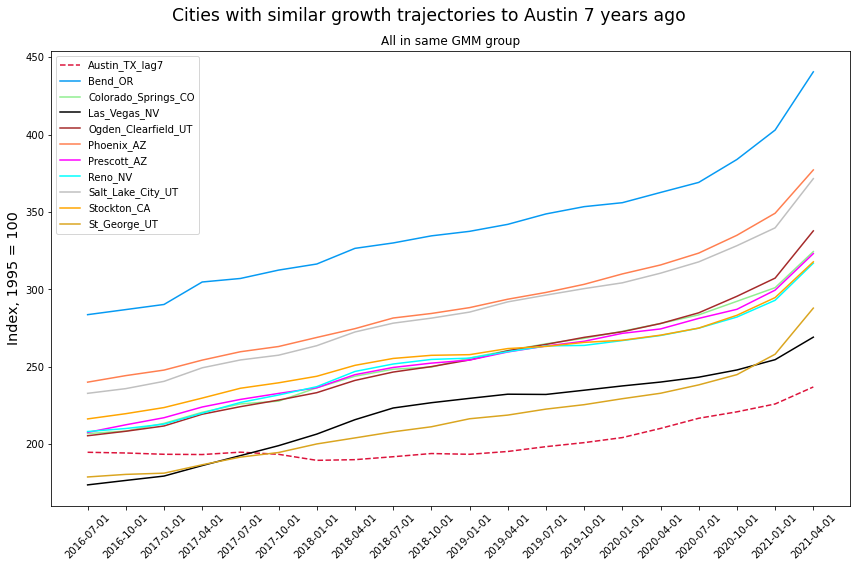

In [49]:
#### All cities in same GMM lag7 group with Austin Tx ####
fig, axs = plt.subplots(figsize=(12, 8))

# Rename cities back to original names, so that the index values can be used
# to subset data_post_rec_index
lag7_group1_df = lag7_group1_df.rename(index={'Ogden Utah': 'Ogden_Clearfield_UT', 
                             'Mobile Alabama': 'Mobile_AL', 
                             'Savannah Georgia':'Savannah_GA'}).copy()

saved_cities_df_index = data_post_rec_index.loc[lag7_group1_df.index.values, :]
austin_index = saved_cities_df_index.iloc[0, ].copy() # split off Austin
saved_cities_df_index = saved_cities_df_index.iloc[1:, ].copy() # and drop Austin from main df

# Offset time periods
austin_index_short = pd.DataFrame(austin_index[:'2014-04-01'])
saved_cities_df_index_short = saved_cities_df_index.loc[:, '2016-07-01':].copy()

# Clean column name & merge Austin df with other cities' df
austin_index_lag7 = austin_index_short.set_index(saved_cities_df_index_short.columns)
austin_index_lag7.rename(columns={'Austin_TX': 'Austin_TX_lag7'}, inplace=True)
merged_cities_lagged_df = pd.concat([austin_index_lag7.T, saved_cities_df_index_short])



for i in range(0, len(merged_cities_lagged_df.index)):
    # Columns = dates, index = time series for particular city
    axs.plot(merged_cities_lagged_df.columns, merged_cities_lagged_df.iloc[i, ],
            label = merged_cities_lagged_df.index[i], # breaking here
            color = color_list_lines[i], linestyle = linestyle_list[i])


plt.xticks(rotation = 45)
plt.suptitle('Cities with similar growth trajectories to Austin 7 years ago',
         fontsize='xx-large')
plt.title('All in same GMM group', fontsize='large')
plt.ylabel('Index, 1995 = 100', fontsize='x-large')
plt.legend()
plt.tight_layout()
plt.show()

**Observations:**
~10 (changes when clustering algo is rerun) of the ~60 cities initially selected were grouped with Austin lagged by 7. This can be interpreted as: the 11 cities above are showing similar housing price growth now to what Austin experienced 7 years ago.

However, further investigation indicates that some of these cities *also* show similar housing price growth when clustered with Austin without a lag. This implies that, like Austin, some of these cities may have already experienced substantial housing price growth over the last decade, so there is less room to run in future prices. Therefore, as the next filter, I replot the line chart comparison above excluding these cities that have already grown similarly to Austin.

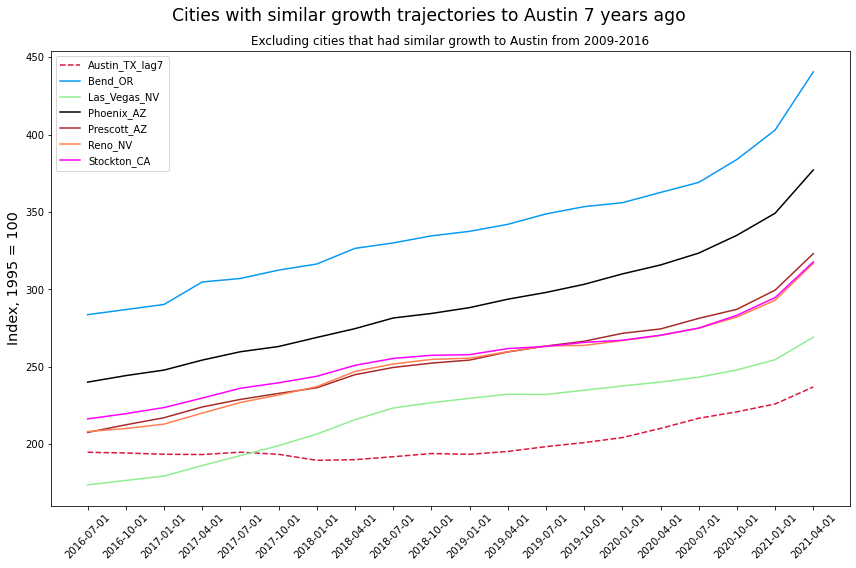

In [50]:
fig, axs = plt.subplots(figsize=(12, 8))

# Rename cities back to original names, so that the index values can be used
# to subset data_post_rec_index
saved_cities = saved_cities.rename(index={'Ogden Utah': 'Ogden_Clearfield_UT', 
                             'Mobile Alabama': 'Mobile_AL', 
                             'Savannah Georgia':'Savannah_GA'}).copy()

saved_cities_df_index = data_post_rec_index.loc[saved_cities.index.values, :].copy()
austin_index = saved_cities_df_index.iloc[0, ].copy() # split off Austin
saved_cities_df_index = saved_cities_df_index.iloc[1:, ].copy() # and drop Austin from main df

# Offset time periods
austin_index_short = pd.DataFrame(austin_index[:'2014-04-01'])
saved_cities_df_index_short = saved_cities_df_index.loc[:, '2016-07-01':].copy()

austin_index_lag7 = austin_index_short.set_index(saved_cities_df_index_short.columns)
austin_index_lag7.rename(columns={'Austin_TX': 'Austin_TX_lag7'}, inplace=True)
merged_cities_lagged_df = pd.concat([austin_index_lag7.T, saved_cities_df_index_short])

for i in range(0, len(merged_cities_lagged_df.index)):
    # Columns = dates, index = time series for particular city
    axs.plot(merged_cities_lagged_df.columns, merged_cities_lagged_df.iloc[i, ],
            label = merged_cities_lagged_df.index[i], c = color_list_lines[i],
            linestyle = linestyle_list[i])


plt.xticks(rotation = 45)
plt.suptitle('Cities with similar growth trajectories to Austin 7 years ago',
         fontsize='xx-large')
plt.title("Excluding cities that had similar growth to Austin from 2009-2016",
         fontsize='large')
plt.ylabel('Index, 1995 = 100', fontsize='x-large')
plt.legend()
plt.tight_layout()
plt.show()

**Observations:**
The cities in the above plot are currently exhibiting housing price growth similar to what Austin saw 7 years ago, when its market had already begun to appreciate meaningfully but had not yet become prohibitively expensive. **These are the cities to investigate further** in a subsequent analysis.

The housing price indices used in this analysis set the year 1995 = 100. From the above chart, we can see which cities have experienced more growth *prior to* the analysis period, by observing which time series have higher values. The Austin time series, a dotted red line, is the time series that doesn't line up with the dates on the x-axis as it is lagged by 7 years. This is also the why the Austin time series has a lower index value than the other cities in the above chart.

Since we excluded several cities from the chart above, it may well be worth seeing how those excluded cities' housing prices have trended over time. This is shown in the next chart. 

In [51]:
# Create graph showing the cities excluded from the filtered graph
saved_cities_df_index_all_dates = data_index.loc[lag7_group1_df.index.values, ]
bool_mask_excluded = [] 
for city in saved_cities_df_index_all_dates.index:
    if city not in saved_cities.index:
        bool_mask_excluded.append(True)
    else:
        bool_mask_excluded.append(False)
        
similar_growth_since_2009 = saved_cities_df_index_all_dates.loc[bool_mask_excluded].copy()

# Used to use the same color scheme for excluded cities as in the above chart, 
# by subsetting color_list.
# See: https://www.geeksforgeeks.org/python-filter-list-by-boolean-list/
from itertools import compress 
bool_mask_len = len(bool_mask_excluded)

filtered_color_list = color_list_lines[:bool_mask_len] 
filtered_color_list = list(compress(color_list_lines, bool_mask_excluded))

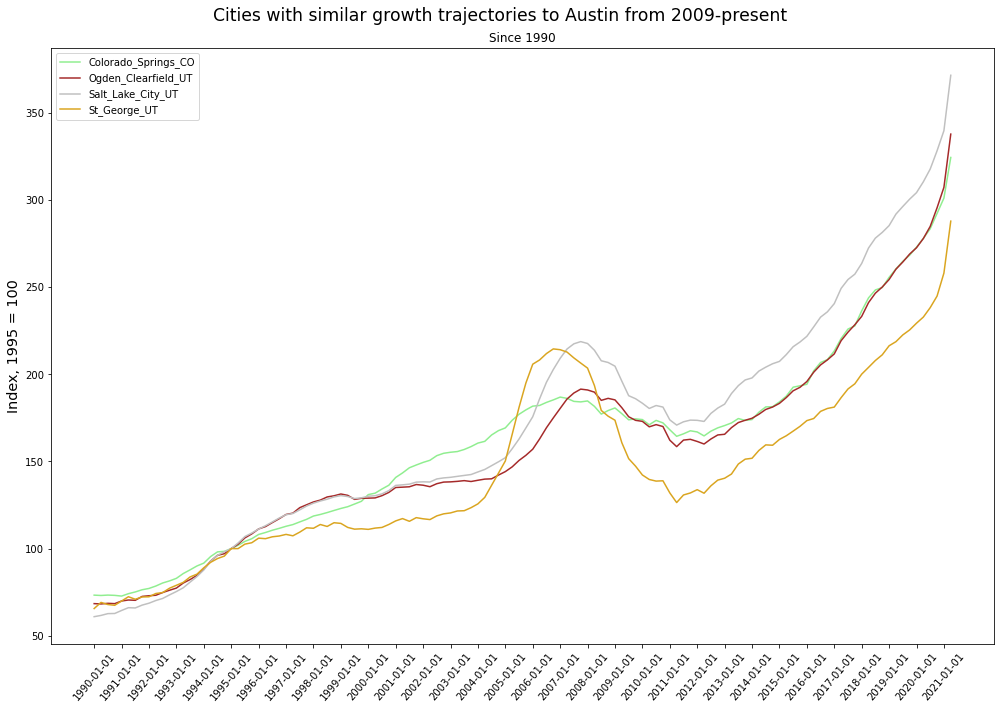

In [52]:
fig, axs = plt.subplots(figsize=(14, 10))

for i in range(0, len(similar_growth_since_2009.index)):
    # Columns = dates, index = time series for particular city
    axs.plot(similar_growth_since_2009.columns, similar_growth_since_2009.iloc[i, ],
            label = similar_growth_since_2009.index[i], 
             c = filtered_color_list[i])
    
axs.set_xticks(axs.get_xticks()[::4]) # only print out each year 
plt.xticks(rotation = 50)
plt.suptitle('Cities with similar growth trajectories to Austin from 2009-present',
         fontsize='xx-large')
plt.title('Since 1990')
plt.ylabel('Index, 1995 = 100', fontsize='x-large')
plt.legend()
plt.tight_layout()
plt.show()

Note: in some iterations of K-means/GMM, this chart will appear blank. This means that no cities were clustered with Austin TX contemporaneously from 2009-Present. This may be an indication that 

However, if cities are showing up in the above These are second tier cities to explore. The idea her is, if they've already exhibited a similar growth trajectory to Austin from 2009-2016, then these markets have already run some, and may be more due for a correction than cities that have only exhibited an upward spike in growth recently for the first time.

Lastly, we'll plot all 10 selected cities over the entire time period, from 1990-present.

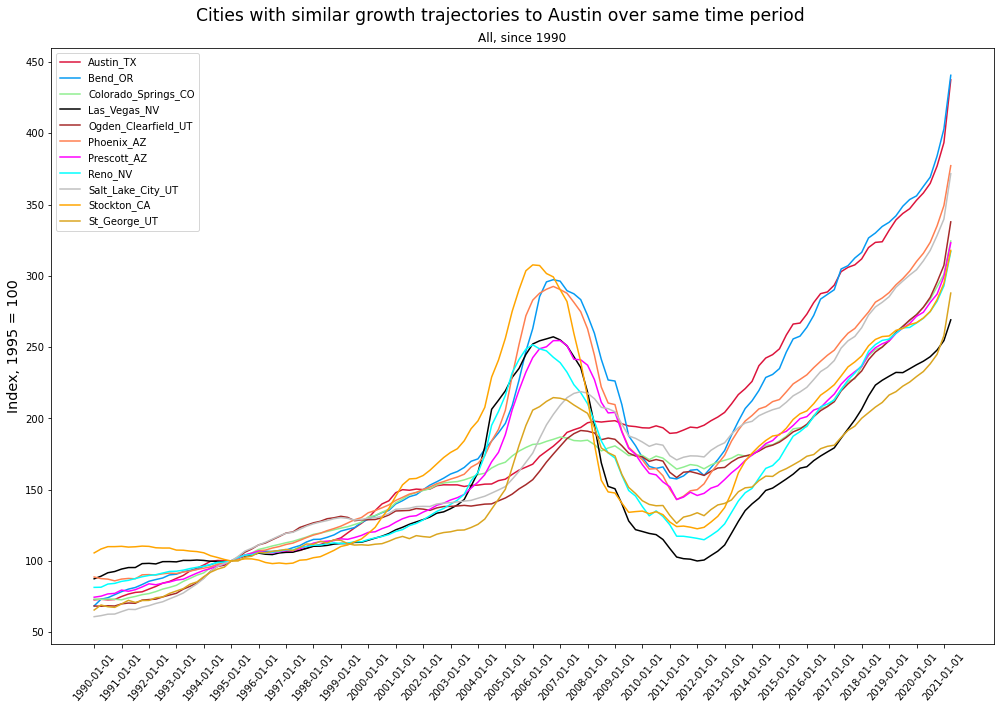

In [53]:
# A look at all cities' growth trajectories since 1990
fig, axs = plt.subplots(figsize=(14, 10))

color_list = ['red', '#069AF3', 'lightgreen', 'black', 'brown', 'coral', 'magenta', 'cyan',
             'silver', 'orange']

# saved_cities_df_index # post recession only
# saved_cities_df_index_all_dates # since 1995
for i in range(0, len(saved_cities_df_index_all_dates.index)):
    # Columns = dates, index = time series for particular city
    axs.plot(saved_cities_df_index_all_dates.columns, saved_cities_df_index_all_dates.iloc[i, ],
            label = saved_cities_df_index_all_dates.index[i], c = color_list_lines[i])
    
axs.set_xticks(axs.get_xticks()[::4]) # only print out each year 
plt.xticks(rotation = 50)
plt.suptitle('Cities with similar growth trajectories to Austin over same time period',
         fontsize='xx-large')
plt.title('All, since 1990')
plt.ylabel('Index, 1995 = 100', fontsize='x-large')
plt.legend()
plt.tight_layout()
plt.show()

**Conclusions:**
In the above chart, the housing bubble that occurred prior to the Great Recession can clearly be seen. Some cities had a sharper corrections than others, but had resumed upward momentum by 2012.

Also note the particularly sharp increase in prices in all cities beginning in 2020. This is due to a broader trend of rising housing prices all over the US, as COVID-19 drove many to seek out home offices with greater space, which raised national demand for housing. Still, this cluster analysis can be used to examine pricing trends before the onset of the pandemic. This can be an indicator of whatever the underlying fundamentals were of that city before the pandemic began.